<div class="alert alert-block alert-info">   

# Vancouver International Airport Electricity Demand Forecasting   

</div>

---

## Table of Contents
[Project description](#Description)  
[Part A: Time plot, trying transformations/adjustments, creating training and test set](#PartA)  
[Part B](#PartB)  
[Introduction & Approach](#Introduction)  
[Exploratory Data Analysis](#EDA1)  
[Potential causes of patterns](#Causes)   
[Exponential Smoothing Model](#ETS)  
[ARIMA model](#ARIMA)  
[Comparison of models](#Compare)  
[Forecasts](#Forecast)  
[Discussion](#Discussion)  
[Explanatory model](#Explanatory)


[Appendix A: ETS Models](#AppendixA)  
[Appendix B: ARIMA Models](#AppendixB)

---

<div class="alert alert-block alert-info">   
<a id="Description"></a>

# Project description
<br>
<br>    
**Objective**  
<br>
    
The main goal of this project is to develop a model to forecast monthly energy use for the Vancouver International Airport (YVR).  
<br>
<br>
  
**Introduction**  
<br>    

Budget planning at YVR requires forecasting the cost of energy to operate the airport. An accurate forecast could help the YVR representatives negotiate more favourable contracts with energy suppliers. 

<br>
<br>   
**Data Available**  
<br>    

Data was taken from 14 years of records from the YVR database. This data set includes information on date, energy use, temperature, terminal area, and number of passengers. Data have been aggregated by month into 168 records (14 years with 12 months each).  
    

<br>
<br>    


| # | Variable | Definition |  
<br>  
| 1 | month | Month and year, e.g.: Nov-98 |
<br>
| 2 | energy | Energy use measured in thousands of kilowatt hours (kWh) |
<br>
| 3 | mean.temp | Mean monthly temperature outside (degrees Celsius) |
<br>
| 4 | total.area | Total area of all terminals (sq. m.) |
<br>
| 5 | total.passengers | Total number of passengers in thousands |
<br>
| 6 | domestic.passengers | Total number of domestic passengers (traveling within Canada) in thousands |
<br>
| 7 | US.passengers | Total number of passengers traveling between Canada and the US in thousands |
<br>
| 8 | international.passengers | Total number of passengers traveling between YVR and countries other than Canada/US |
<br>
<br>
    
In this project, you will develop appropriate models, compare the models, and discuss advantages and limitations of each model. You should select the best model and use it to provide monthly forecasts for energy use for the next three years (January 2011 through December 2013).   
    
</div>

---

<div class="alert alert-block alert-info">   

# Part A
## Time plot, transformations/adjustments, creating training and test set

<a id="PartA"></a>  

</div>


### Import packages

In [1]:
library(dplyr)
library(fpp2)
library(ggplot2)
library(ggfortify)
library(seasonal)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ────────────────────────────────────────────── fpp2 2.4 ──

✔ ggplot2   3.3.6     ✔ fma       2.4  
✔ forecast  8.19      ✔ expsmooth 2.3  



Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast




### Import the data

In [2]:
mydata <- read.csv('Energy use at YVR.csv', header = TRUE, sep =",")


### Create time series

In [3]:
mytimeseries <- ts(mydata[,2:8], start = c(1997, 1), frequency=12)

In [4]:
energy <- ts(mydata[,2], start = c(1997, 1), frequency=12)

In [5]:
temp <- ts(mydata[,3], start = c(1997, 1), frequency=12)

In [6]:
passenger <- ts(mydata[,5], start = c(1997, 1), frequency=12)

In [7]:
d.passenger <- ts(mydata[,6], start = c(1997, 1), frequency=12)


In [8]:
us.passenger <- ts(mydata[,7], start = c(1997, 1), frequency=12)

In [9]:
int.passenger <- ts(mydata[,8], start = c(1997, 1), frequency=12)


### Time plot

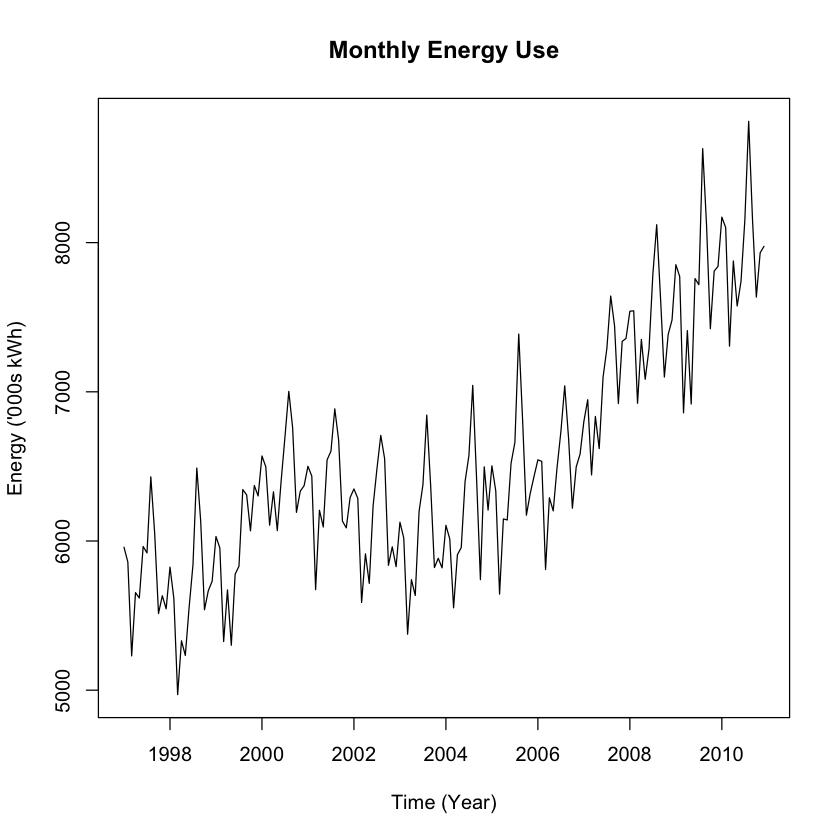

In [10]:
#png("a2.png")
plot(energy, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Monthly Energy Use")
#dev.off()


### Box-Cox transformation

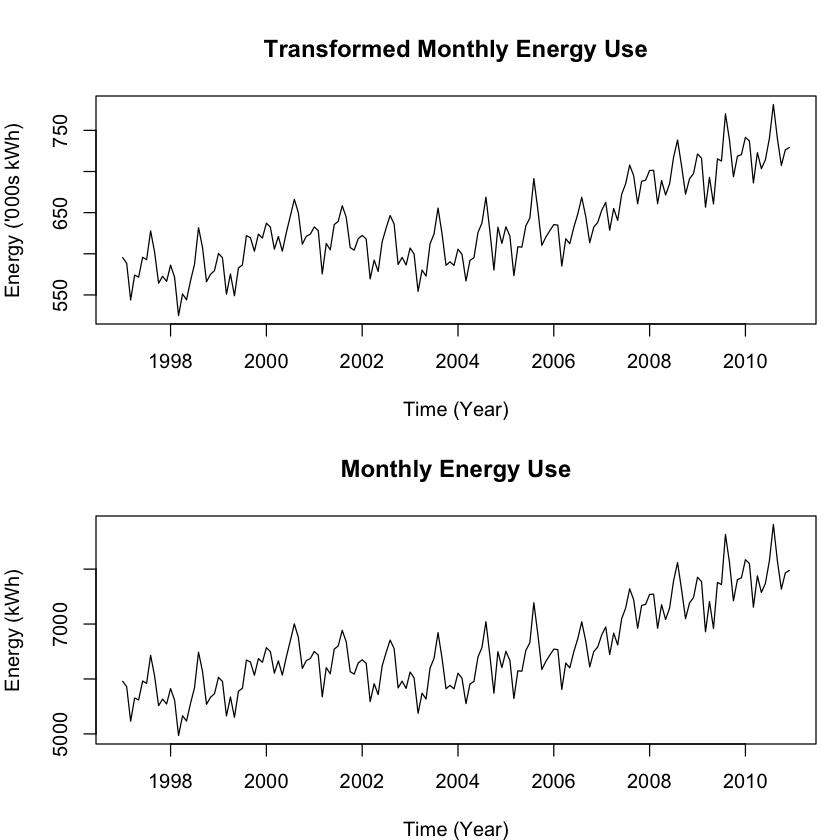

In [11]:
#png("a3.png")
par(mfrow=c(2,1), mar=c(4,4,4,1))
lambda <- BoxCox.lambda(energy)
plot(BoxCox(energy, lambda), xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Transformed Monthly Energy Use")
plot(energy, xlab="Time (Year)", ylab="Energy (kWh)", main="Monthly Energy Use")
#dev.off()


### Calendar adjustment for number of days in each month

In [12]:
energy.m.adj <- energy/monthdays(energy)

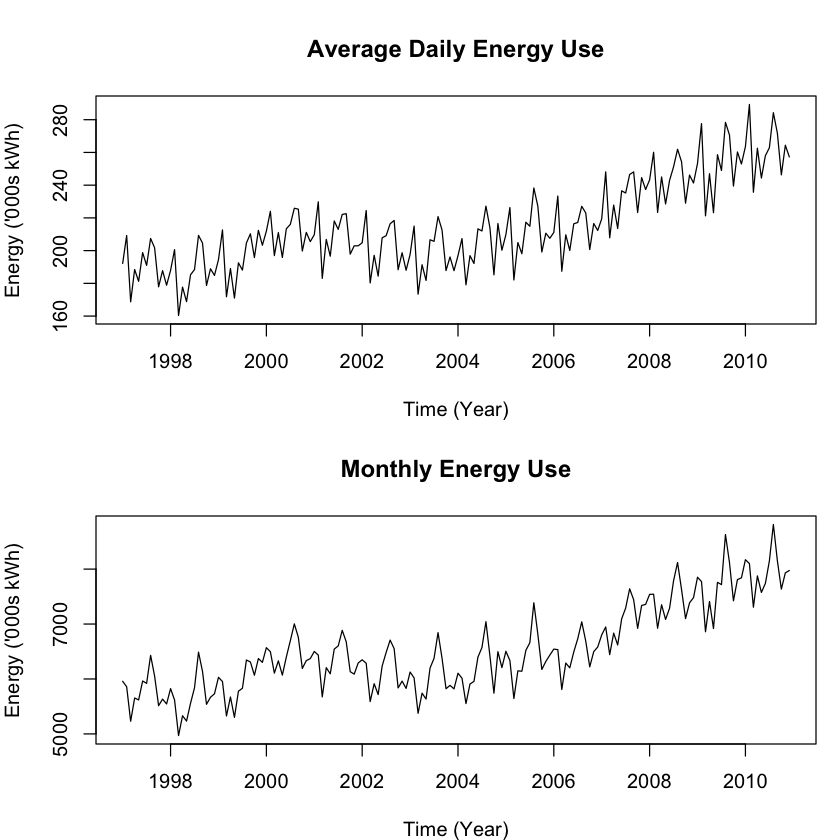

In [13]:
#png("a4.png")
par(mfrow=c(2,1), mar=c(4,4,4,1))
plot(energy.m.adj, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Average Daily Energy Use")
plot(energy, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Monthly Energy Use")
#dev.off()

### Divide the data into the training set and the test set

In [14]:
energy.train <- window(energy, c(1997,1), c(2007,12))
energy.test <- window(energy, start = c(2008,1), end = c(2010,12))

energy.test

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,7540,7543,6923,7351,7084,7288,7788,8120,7628,7099,7385,7481
2009,7852,7773,6859,7410,6918,7759,7718,8630,8121,7423,7809,7841
2010,8171,8101,7306,7877,7575,7740,8149,8813,8154,7635,7932,7975


----

<div class="alert alert-block alert-info">   

# Part B
<a id="PartB"></a>  
## Analysis and forecasts

</div>

This projects aims to use historical data from January 1997 to December 2010 to predict forecast monthly energy demand at the YVR airport. We divide the dataset into 2 parts: a training set from Jan 1997 to Dec 2007 to train the model, and a validation set from Jan 2008 to Dec 2010 to test performance for 3-year foreasts.    

First, we decompose the training data to identify trend/cycle and seasonal patterns. These features will allow us to understand the data better and allow us to choose the appropriate forecasting models. Accuracy measures will be taken for each method in order to chooe the best method.  

4 basic methods - mean, naive, seasonal naive, and drift - are used as benchmarks for more complex models. Then we develop an ETS model, using appropriate parameters inferred from previous analysis. We also perform ACF/PACF analysis, which serves as the basis to build an ARIMA model. We also conduct goodness of fits and residuals analysis for the ETS and ARIMA models.

After all models have been developed, we identify the best method by comparing the accuracy measures, goodness of fits, and plotting performance. The final model will be used to forecast the desired data from Jan 2011 to Dec 2013.

Since energy demand also depends on other factors, such as total passengers travelled and terminal services areas, an approach for explanatory linear regression model is also discussed.

----

<div class="alert alert-block alert-warning">
<a id="EDA1"></a>

# Exploratory Data Analysis
</div>

### Data decomposition

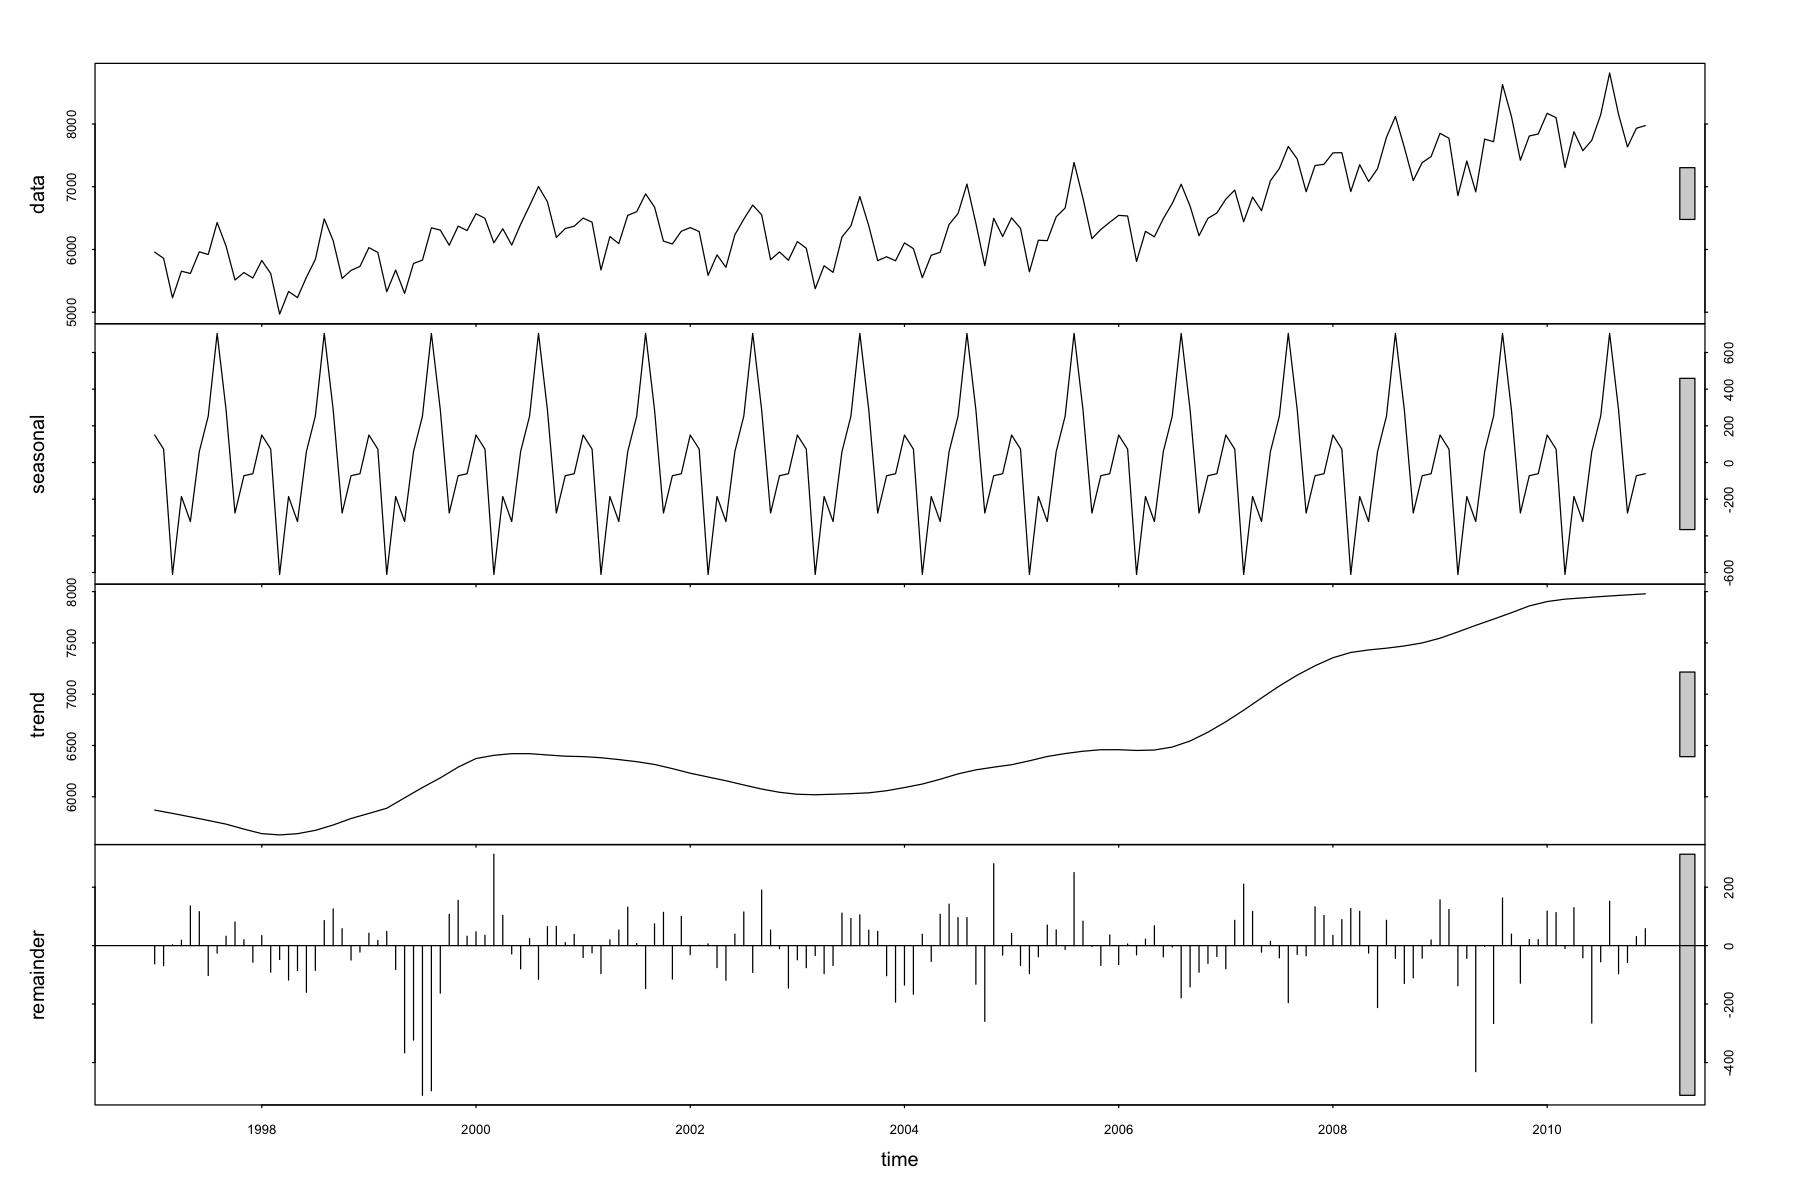

In [15]:
options(repr.plot.width=15, repr.plot.height=10)
energy_stl <- stl(energy, s.window='periodic', robust = TRUE)
plot(energy_stl)

**Seasonality:** This data has a yearly/12-month seasonal pattern. Throughout the 14-year period, there are 14 peaks which occur mainly in August. There is also secondary peaks in December-February. The level of seasonality only varies slightly with the trend.

**Trend/cycle**: The data shows a primarily linear, upward trend. However, it is interesting to see that this trend's upward slope was basically flattened from 2001 to 2006. This trend could also be heading towards a peak of a cycle, but no clear signals indicate that a cycle is present throughout this 14-year period.

**Unusual features (if any)**: The remainder component shows a big drop for in 1999 that virtually offset the supposed-ly peak season of that year. There are also a few other significant drops that occurs at the later end of the period.

<div class="alert alert-block alert-warning">
<a id="Causes"></a>

# Potential causes 
</div>

**Seasonality:** The peaks for seasonal energy demand is caused by peaks in passenger travels. These peaks occur mainly in August when people return from summer hoiday travels. There is also secondary peaks in December-February which represents winter holiday/Chirstmas travels. 

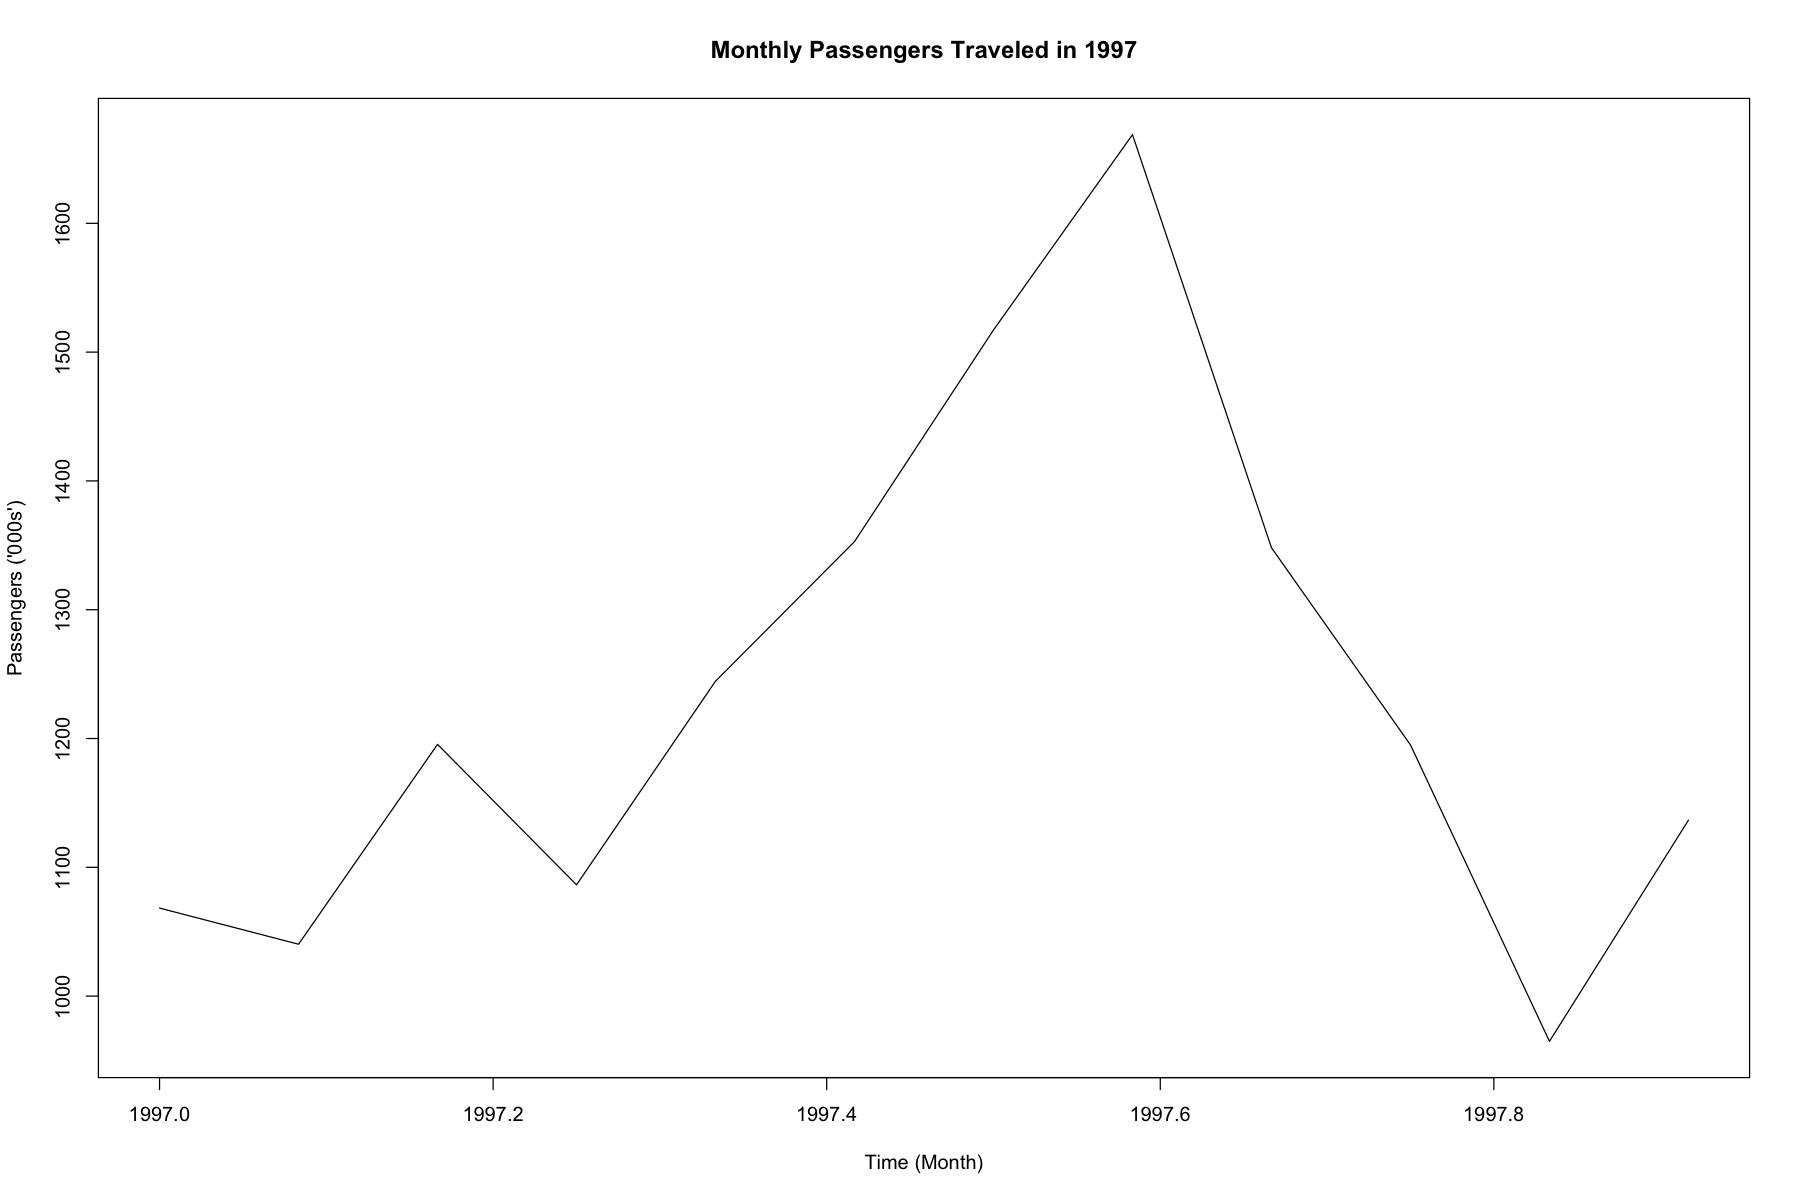

In [16]:
passenger1997 <- ts(mydata[,5], start = c(1997, 1), end = c(1997,12), frequency=12)
#passenger1997

plot(passenger1997, xlab="Time (Month)", ylab="Passengers ('000s')", main="Monthly Passengers Traveled in 1997")


**Trend/cycle**: Similar to the seasonal component, the trend/cycle component is mostly affected by total number of passengers. The reduced slope of 2001-2006 is also reflected in the drop for total passengers, which could have been the resulted of increased air travel risks/security measures that were associated with the aftermath of 9/11.

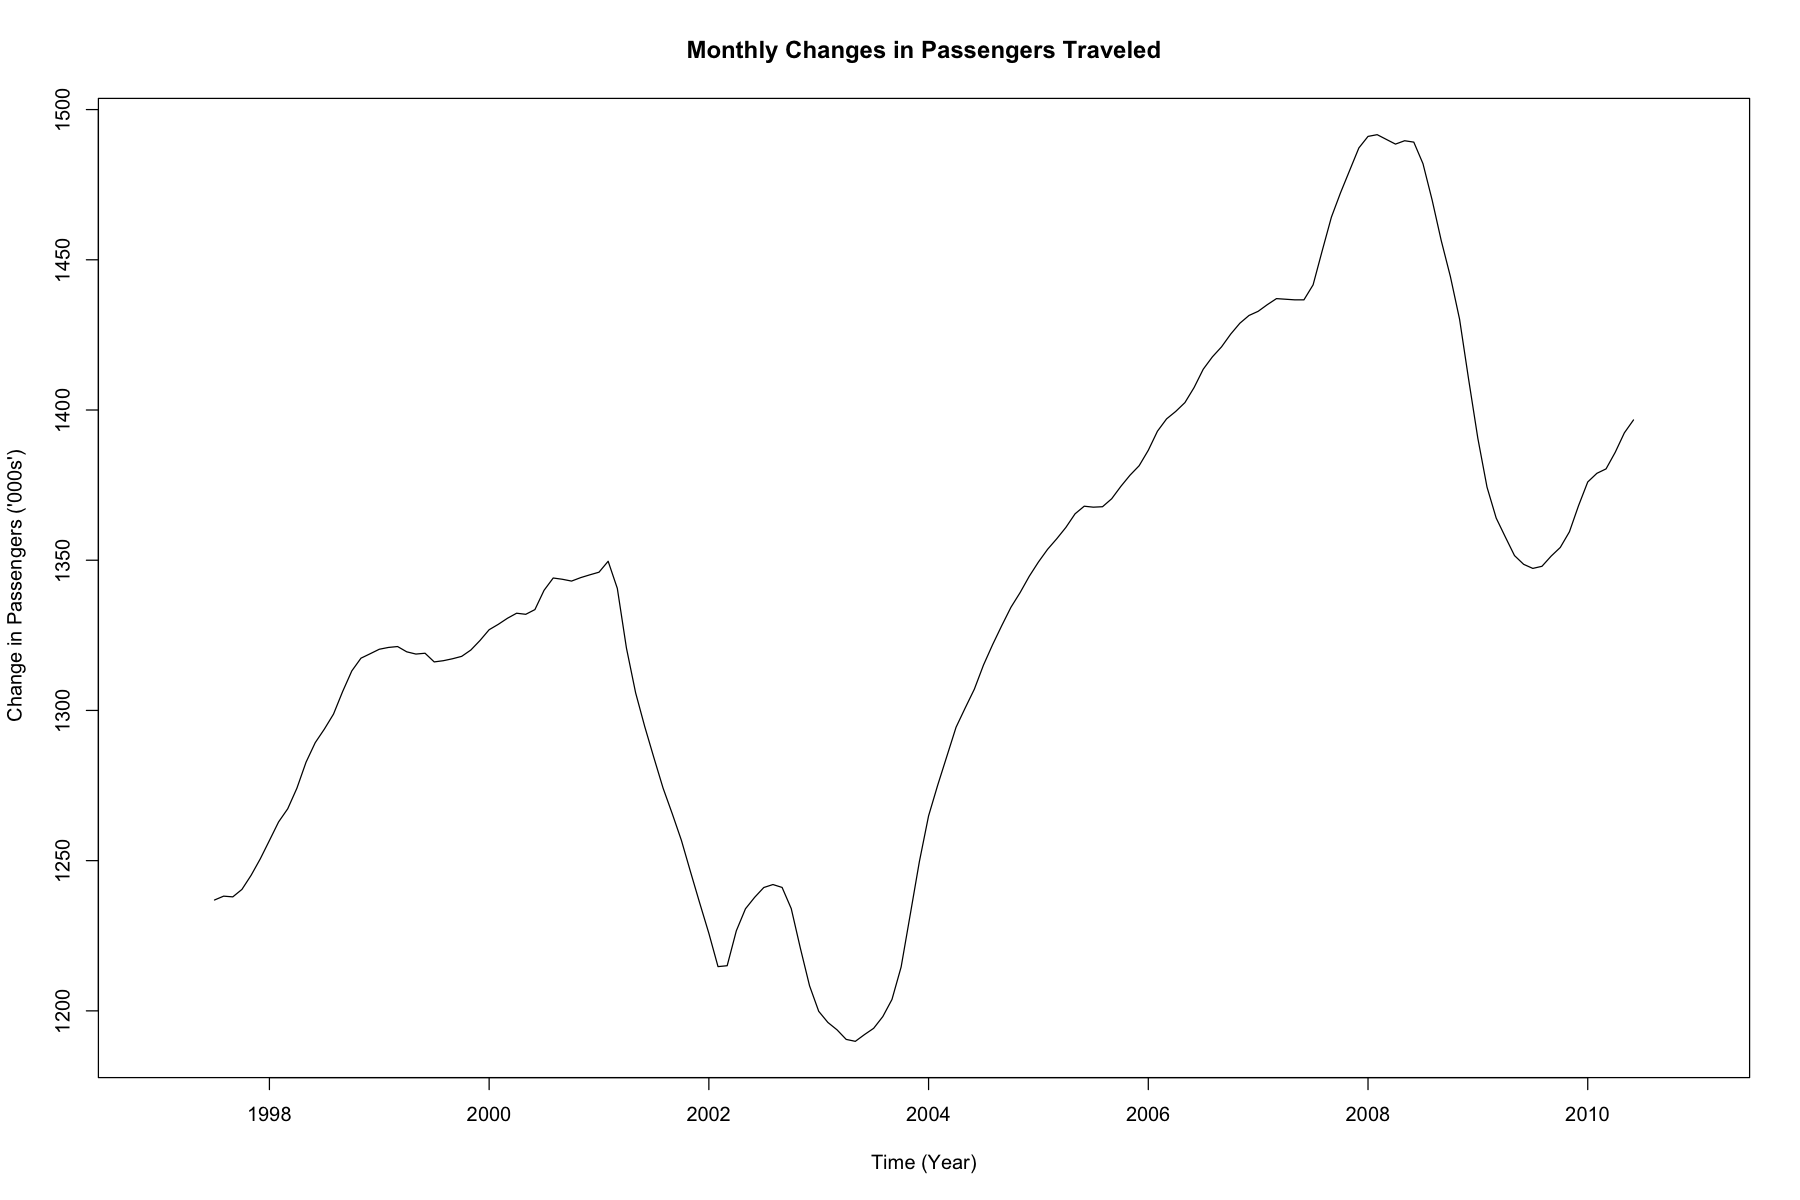

In [17]:
pass_trend =  ma(passenger, order = 12)
plot(pass_trend, xlab="Time (Year)", ylab=" Change in Passengers ('000s')", main="Monthly Changes in Passengers Traveled")

**Unusual features (if any)**: The drop in 1999 coincides with YVR terminal area expansion in 1999. This could mean that the airport reduced its services capacity during the time of the construction, thus lead to lower energy demand. The later drops also happen at the same time as later minor are expansions from 2006 onwards.

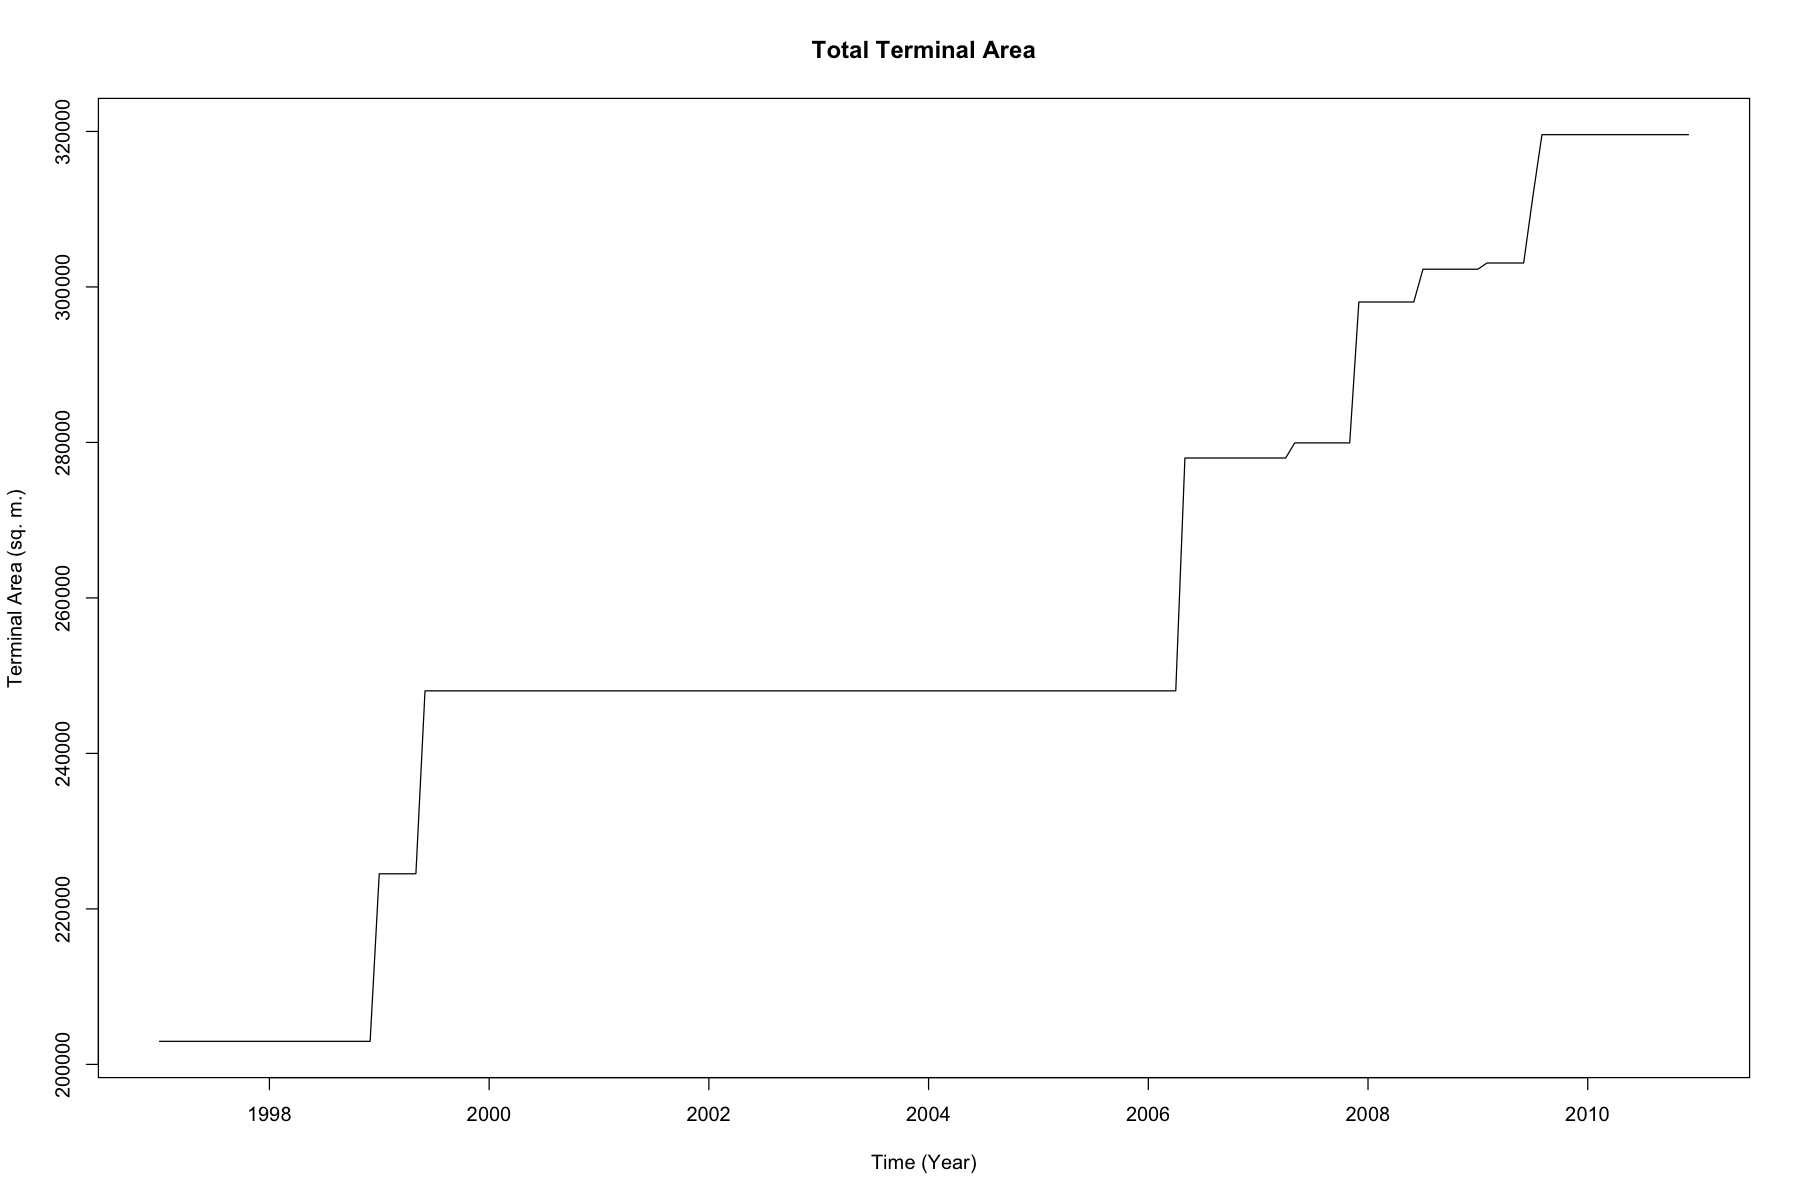

In [18]:
area <- ts(mydata[,4], start = c(1997, 1), frequency=12)
plot(area, xlab="Time (Year)", ylab="Terminal Area (sq. m.)", main="Total Terminal Area")

<div class="alert alert-block alert-success">
<a id="Basic"></a>

# Basic forecasting methods
</div>  

 
### Model fitting
    

In [19]:
#Naive model
energy_naive <- naive(energy.train,36)
naive_acc <- accuracy(energy_naive,energy.test)

#Seasonal naive model
energy_snaive <- snaive(energy.train,36)
snaive_acc <- accuracy(energy_snaive,energy.test)

#Mean model
energy_mean <- meanf(energy.train, 36)
mean_acc <- accuracy(energy_mean,energy.test)

#Drift model
energy_drift <- rwf(energy.train, drift = TRUE, 36)
drift_acc <- accuracy(energy_drift, energy.test)

 
## Visual comparison and assessment of basic methods 
    

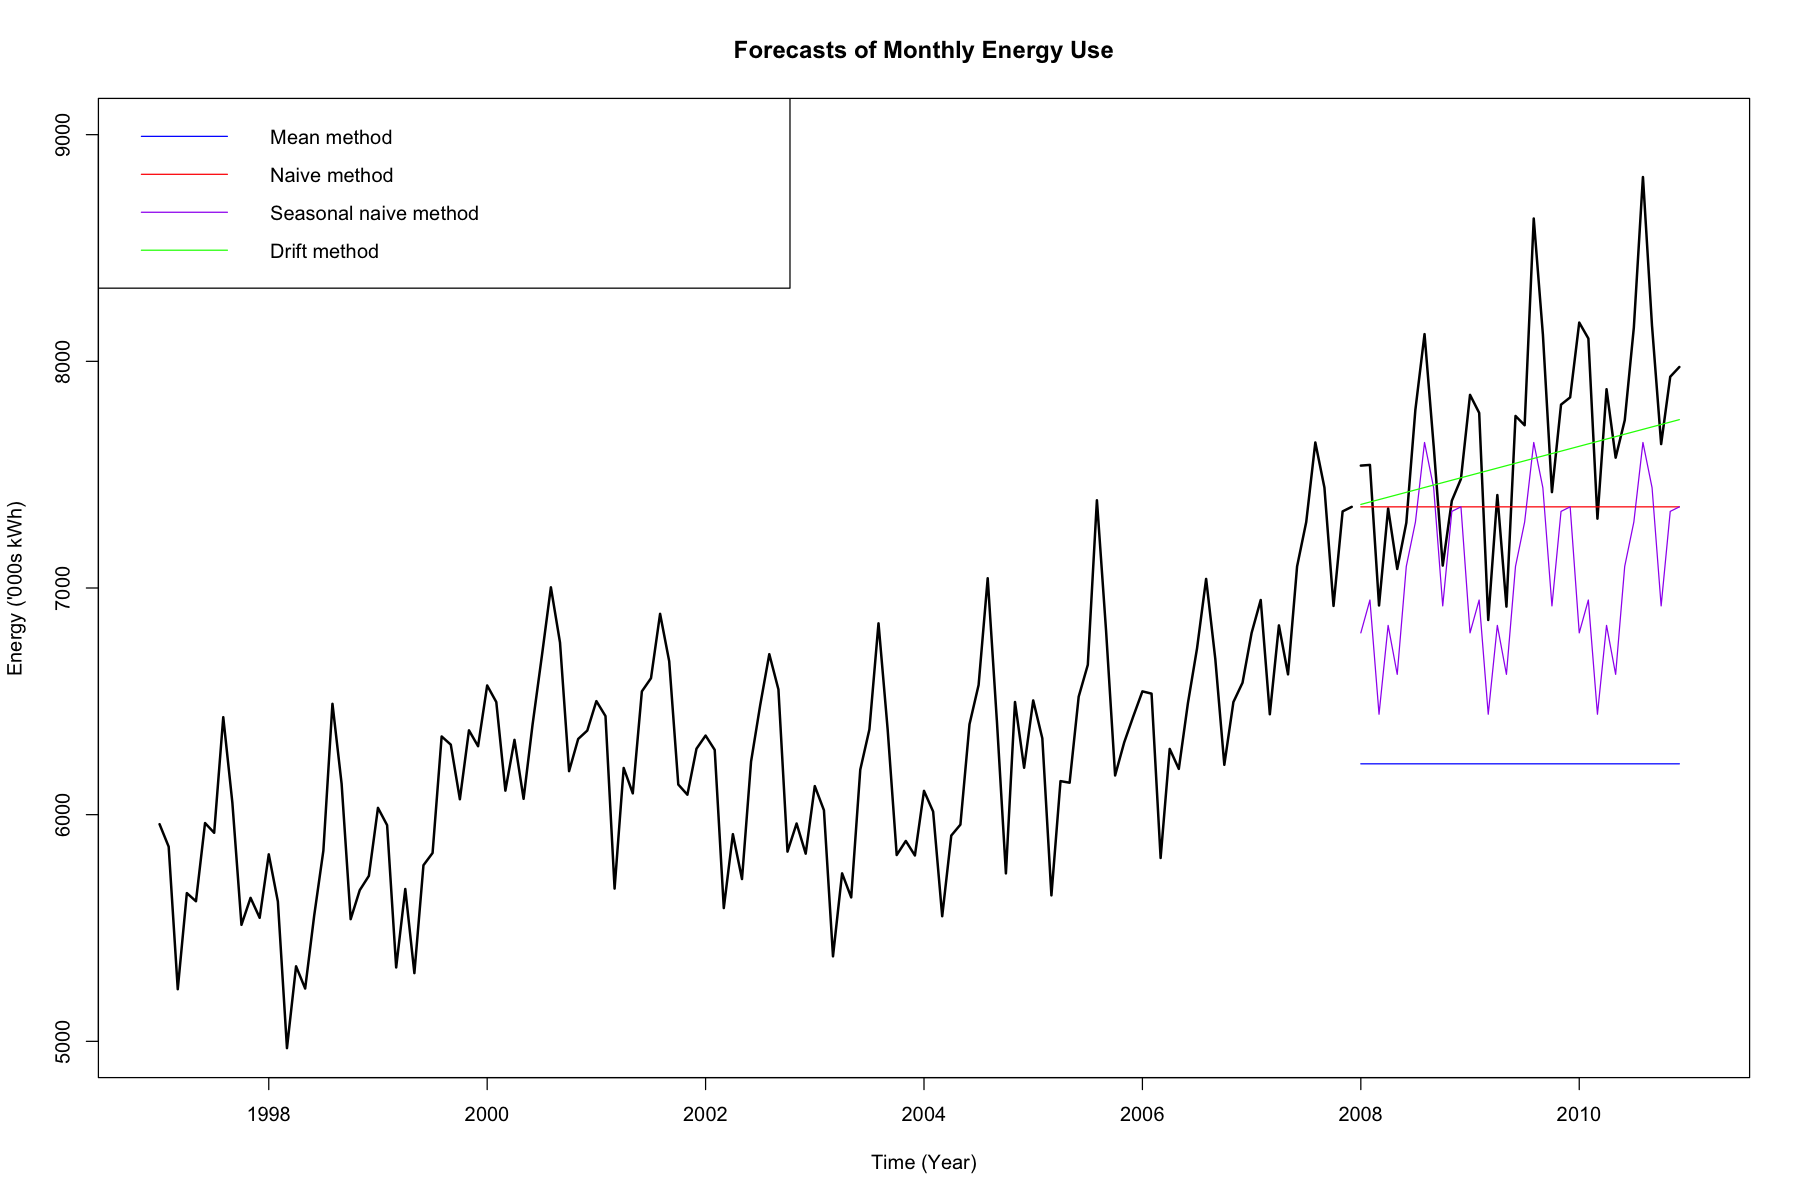

In [20]:
plot(energy.train, lwd=2, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Forecasts of Monthly Energy Use",xlim=c(1997,2011),ylim=c(5000,9000))
lines(energy.test, lwd=2)
lines(energy_mean$mean,col='blue')
lines(energy_naive$mean,col='red')
lines(energy_snaive$mean,col='purple')
lines(energy_drift$mean,col='green')
legend("topleft",lty=1,col=c('blue','red','purple','green'), legend=c("Mean method","Naive method","Seasonal naive method","Drift method"))

Based on the visualization, both the **drift** and **seasonal naive** methods can produce fairly acceptable forecasts.  

However, the **drift method** should be superior since it can track the increasing trend, as wel as having the starting point closer to the start of the test data.

## Accuracy measures 

In [21]:
method <- c("mean method", "naive method", "seasonal naive method", "drift method")
basic_acc <- cbind(method, rbind(round(mean_acc[2,c(2,3,5,6)],1),
                    round(naive_acc[2,c(2,3,5,6)],1),
                    round(snaive_acc[2,c(2,3,5,6)],1),
                    round(drift_acc[2,c(2,3,5,6)],1)))
basic_acc

method,RMSE,MAE,MAPE,MASE
mean method,1528.5,1463.8,18.8,5.5
naive method,550.1,443.2,5.6,1.7
seasonal naive method,698.7,626.8,8,2.4
drift method,416,328.5,4.2,1.2


## Comparison of basic methods 

The **drift method** performs the best since it has lowest error values of all 4.

The MASE of 1.2 means that the method *should* perform worse than the seasonal naive method. However, the seasonal naive performs much worse in this case (MASE of 2.4), since the trend increases greatly for the test set, which it fails to capture. On the other hand, the drift method could capture this trend well enough, thus lower having lower MASE than the seasonal naive method.

----

<div class="alert alert-block alert-success">
<a id="ETS"></a>

# Exponential Smoothing (ETS) model

</div>    

 
### Model fitting: ETS(A, A, A)
    

In [22]:
#Holt-Winters additive model
energy_hwa <- hw(energy.train, seasonal = 'additive', h =36)

#Equivalent ETS model
energy_ets <- ets(energy.train, model = 'AAA', damped=FALSE)

In [23]:
summary(energy_hwa$model)

Holt-Winters' additive method 

Call:
 hw(y = energy.train, h = 36, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.7846 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = 5879.3546 
    b = 12.3652 
    s = -36.7977 -27.2016 -238.1219 321.0426 666.3048 232.4424
           58.5104 -349.8579 -192.2142 -564.3842 38.3341 91.9432

  sigma:  134.6878

     AIC     AICc      BIC 
1955.855 1961.224 2004.863 

Training set error measures:
                    ME     RMSE      MAE         MPE     MAPE      MASE
Training set -1.171192 126.2613 98.95847 -0.06213835 1.594299 0.3734517
                    ACF1
Training set 0.005411505

One could interpret that the error, trend, and seasonal variances are fairly constant through time based on the earlier decomposition visualization. Therefore, the ETS method with additive error, trend, and seasonal components (or Holt-Winters additive method) is applicable.

## Model plot 

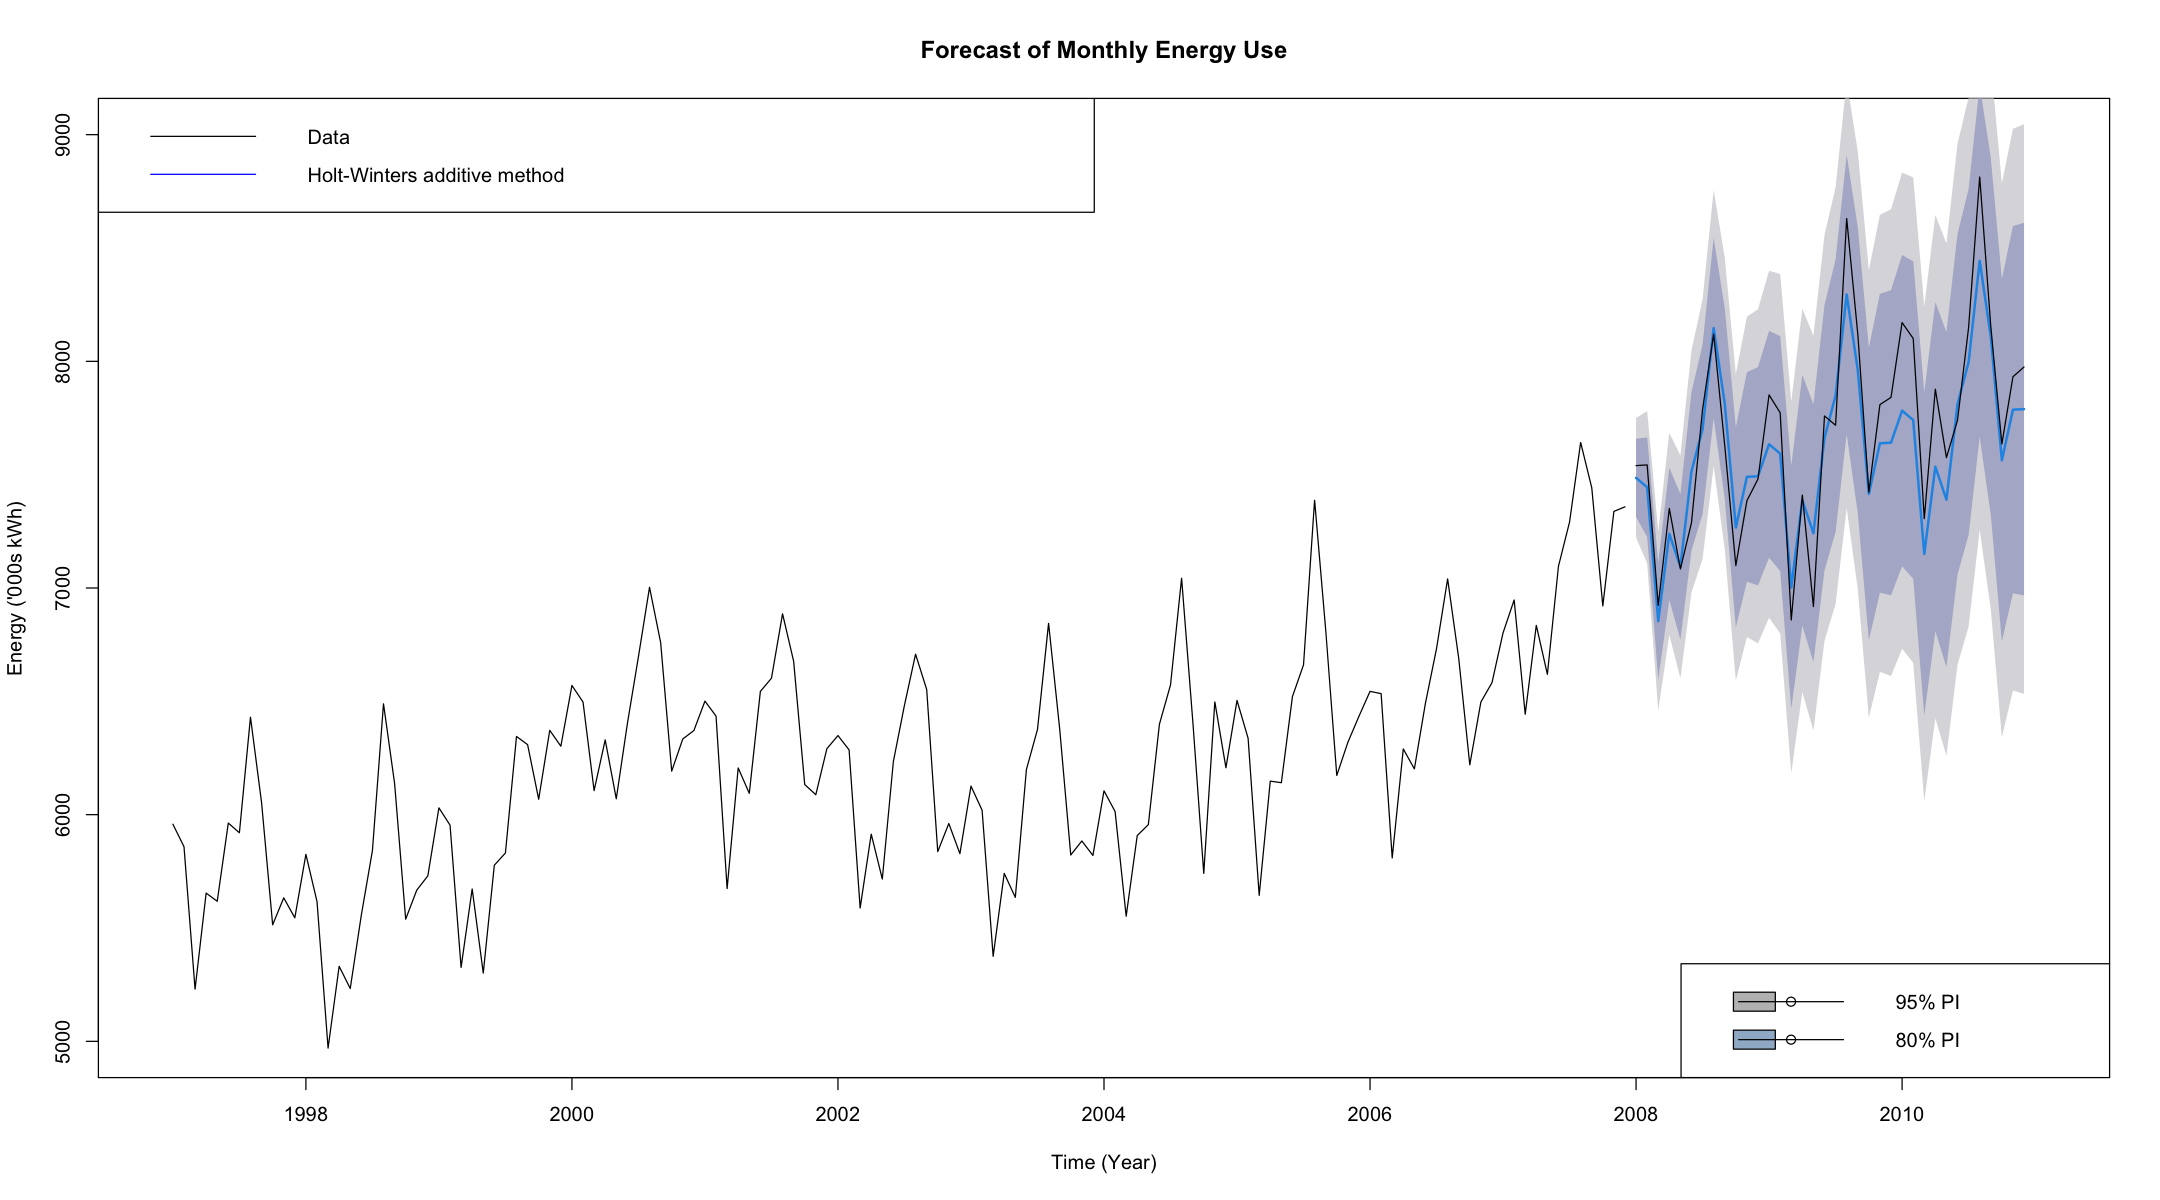

In [24]:
options(repr.plot.width=18, repr.plot.height=10)
plot(energy_hwa, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Forecast of Monthly Energy Use",xlim=c(1997,2011),ylim=c(5000,9000))
lines(energy.test)
legend("topleft",lty=1,col=c('black','blue'), legend=c("Data","Holt-Winters additive method"))
legend("bottomright",lty=1, fill=c("gray","slategray3"), c("95% PI", "80% PI"),pch=1) 

## Goodness of fit 

In [53]:
ETS <- c("HW Additive", "HW Multiplicative", "ETS(A,N,A)")
aicc <- c(round(energy_hwa$model$aicc,1),
          round(energy_hwm$model$aicc,1),
          round(energy_ets$aicc,1))
ETS_aiccs <- cbind(ETS, aicc)
ETS_aiccs

ETS,aicc
HW Additive,1961.2
HW Multiplicative,1984.2
"ETS(A,N,A)",1956.8


The Holt-Winters additive method has moderate goodness of fit to the training set. It has lower AICc than the Holt-Winers multiplicative method, but slightly lower than the ETS(A,N,A) method.

## Accuracy measures 

In [26]:
hwa_acc <- accuracy(energy_hwa,energy.test)
hwa_acc

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-1.171192,126.2613,98.95847,-0.06213835,1.594299,0.3734517,0.005411505,NA
Test set,78.013711,188.9986,155.89604,0.92977736,2.003689,0.5883240,0.308229307,0.3928985


## Accuracy of forecasts 

In [27]:
method2 <- c("mean method", "naive method", "seasonal naive method", "drift method","holt-winters additive method")

hwa.basic_acc <- cbind(method2,rbind(round(mean_acc[2,c(2,3,5,6)],1),
                    round(naive_acc[2,c(2,3,5,6)],1),
                    round(snaive_acc[2,c(2,3,5,6)],1),
                    round(drift_acc[2,c(2,3,5,6)],1),
                    round(hwa_acc[2,c(2,3,5,6)],1)))
hwa.basic_acc

method2,RMSE,MAE,MAPE,MASE
mean method,1528.5,1463.8,18.8,5.5
naive method,550.1,443.2,5.6,1.7
seasonal naive method,698.7,626.8,8,2.4
drift method,416,328.5,4.2,1.2
holt-winters additive method,189,155.9,2,0.6


The HW Additive method performs better than all of the previous basic models. This model has lower values accross all 4 RMSE, MAE, MAPE, and MASE indicators. The forecast line can also capture the test set's both trend and seasonality well.

## Residual diagnostics 

In [28]:
#Mean residuals
hwa_res <- residuals(energy_hwa)
mean_hwa_res <- mean(hwa_res,nam.rm=TRUE)
mean_hwa_res

[1] -1.171192


	Ljung-Box test

data:  Residuals from Holt-Winters' additive method
Q* = 14.031, df = 8, p-value = 0.08095

Model df: 16.   Total lags used: 24



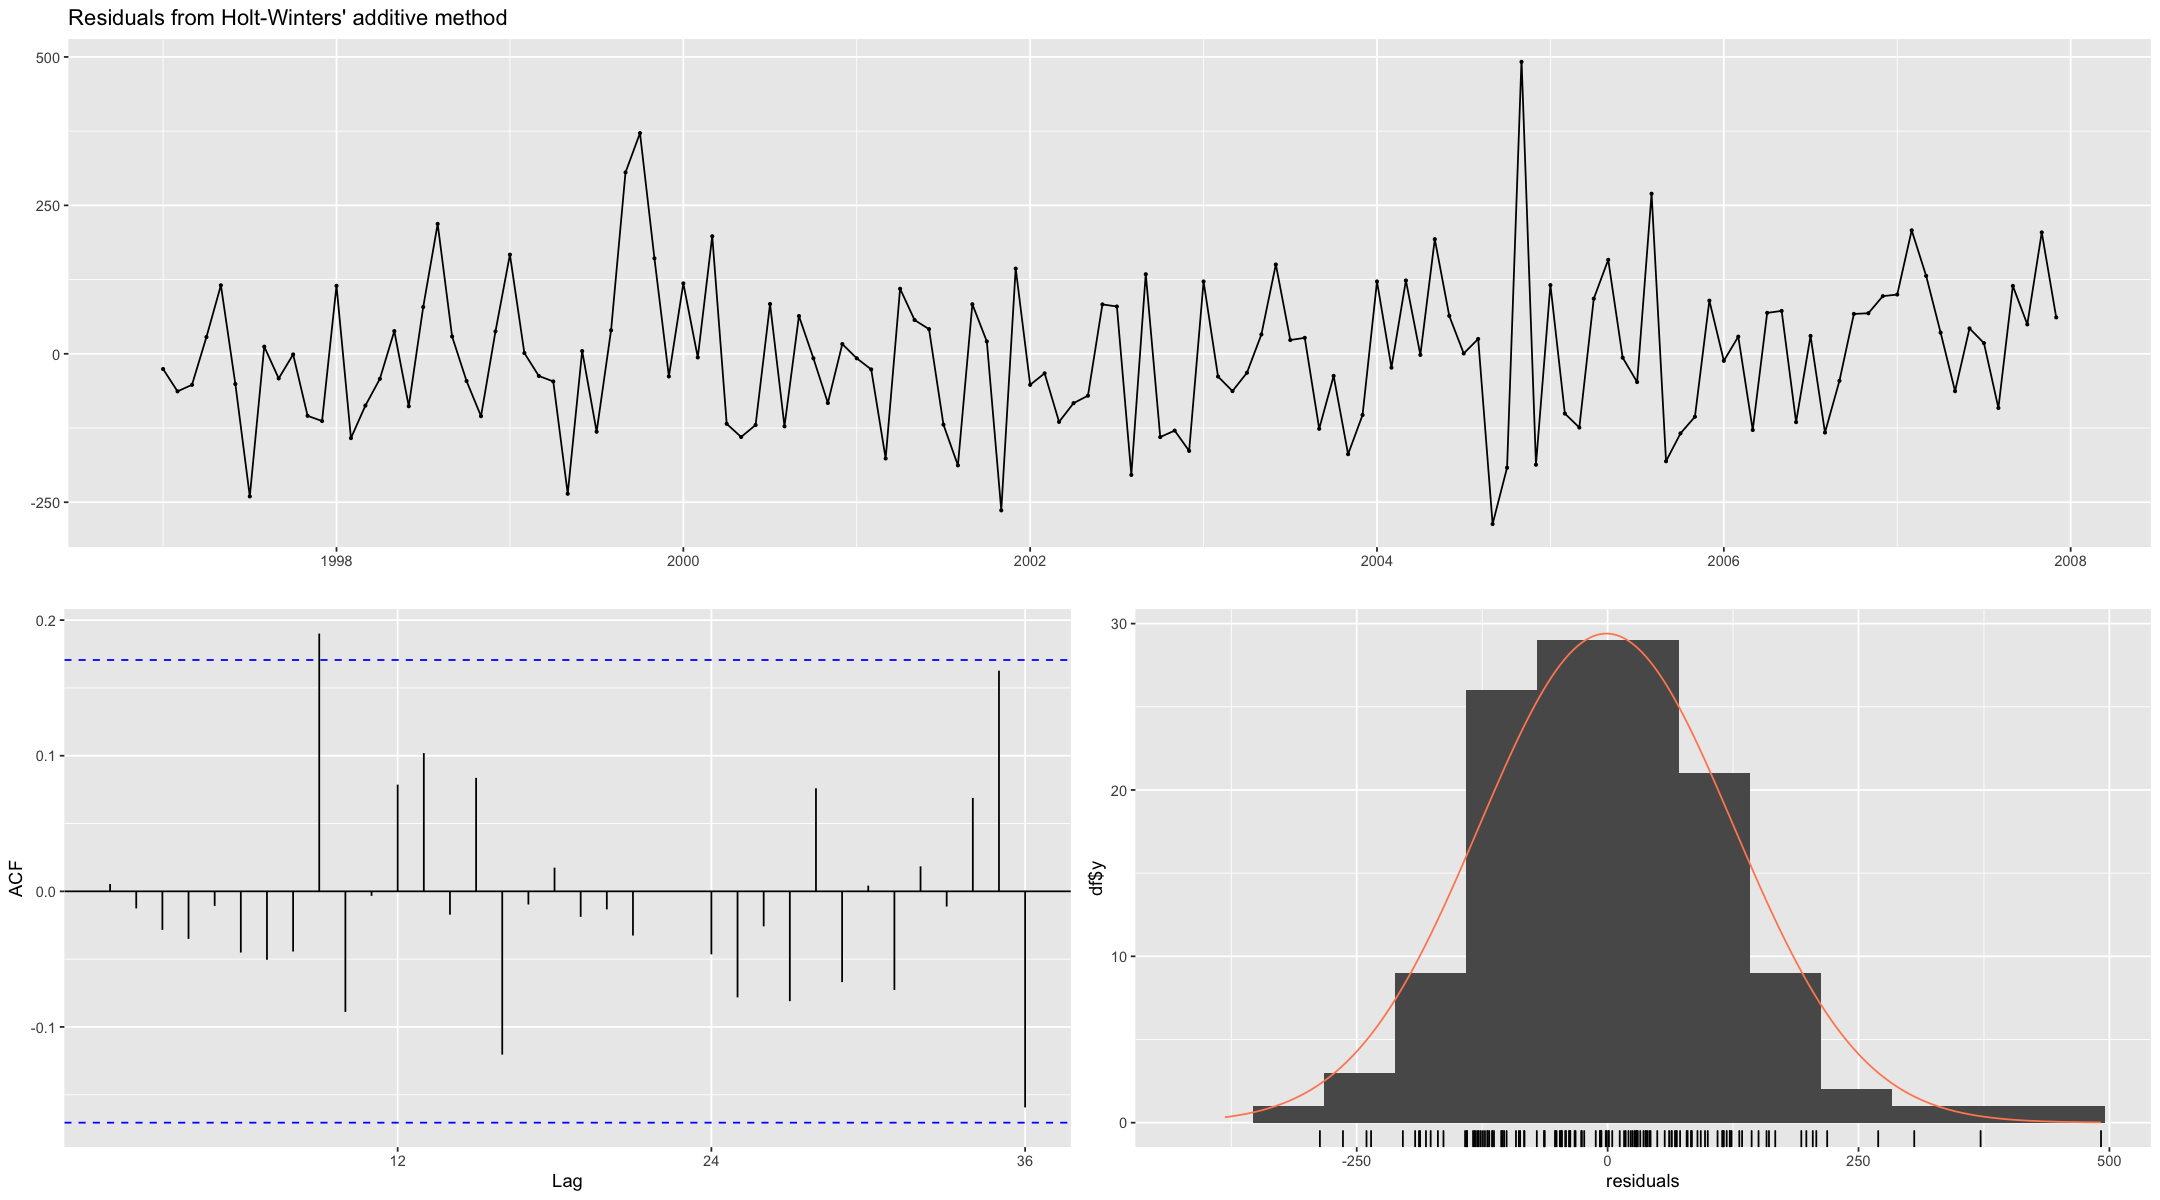

In [29]:
#Visualization
checkresiduals(energy_hwa)

Mean residuals is relatively close to 0, which means little-to-no bias.  
There is no significant autocorrelations either.  
Variance of residuals stays approximately constant through time.    
Residuals are approximately normally distributed.  

 
### Portmanteau autocorrelation test
    

In [30]:
Box.test(hwa_res, type="Ljung", lag=24)


	Box-Ljung test

data:  hwa_res
X-squared = 14.031, df = 24, p-value = 0.9459


H0: the first 24 autocorrelations are not significantly different from a white noise process    
HA: the first 24 autocorrelations are significantly different from a white noise process

Lags tested: 24

Test statistics: 14.031

p-value: 0.9459 ( > 0.05)

We cannot reject th hypothesis that there are no significant autocorrelations for the first 24 lags of the residuals.

----

<div class="alert alert-block alert-success">
<a id="ARIMA"></a>
    
# ARIMA model
    
    
</div>    

 
### Model fitting: ARIMA(1, 1, 0)(0, 1, 1) with constant
    

In [31]:
#ARIMA(1,1,0)(0,1,1)[12] with constant
energy_arima <- Arima(energy.train,order=c(1,1,0),seasonal=c(0,1,1),include.constant=TRUE,lambda = lambda)
energy_arima

Series: energy.train 
ARIMA(1,1,0)(0,1,1)[12] 
Box Cox transformation: lambda= 0.6931483 

Coefficients:
          ar1     sma1
      -0.1884  -0.9366
s.e.   0.0908   0.2964

sigma^2 = 86.04:  log likelihood = -443.84
AIC=893.68   AICc=893.89   BIC=902.01

## Appropriateness of model 

The ACF decreases slowly while the PACF cuts of at lag-1 suggests an AR(1) model. The original data has a positive trend so 1st-order differencing is needed. The mean is also not close to 0 so a constant is needed.

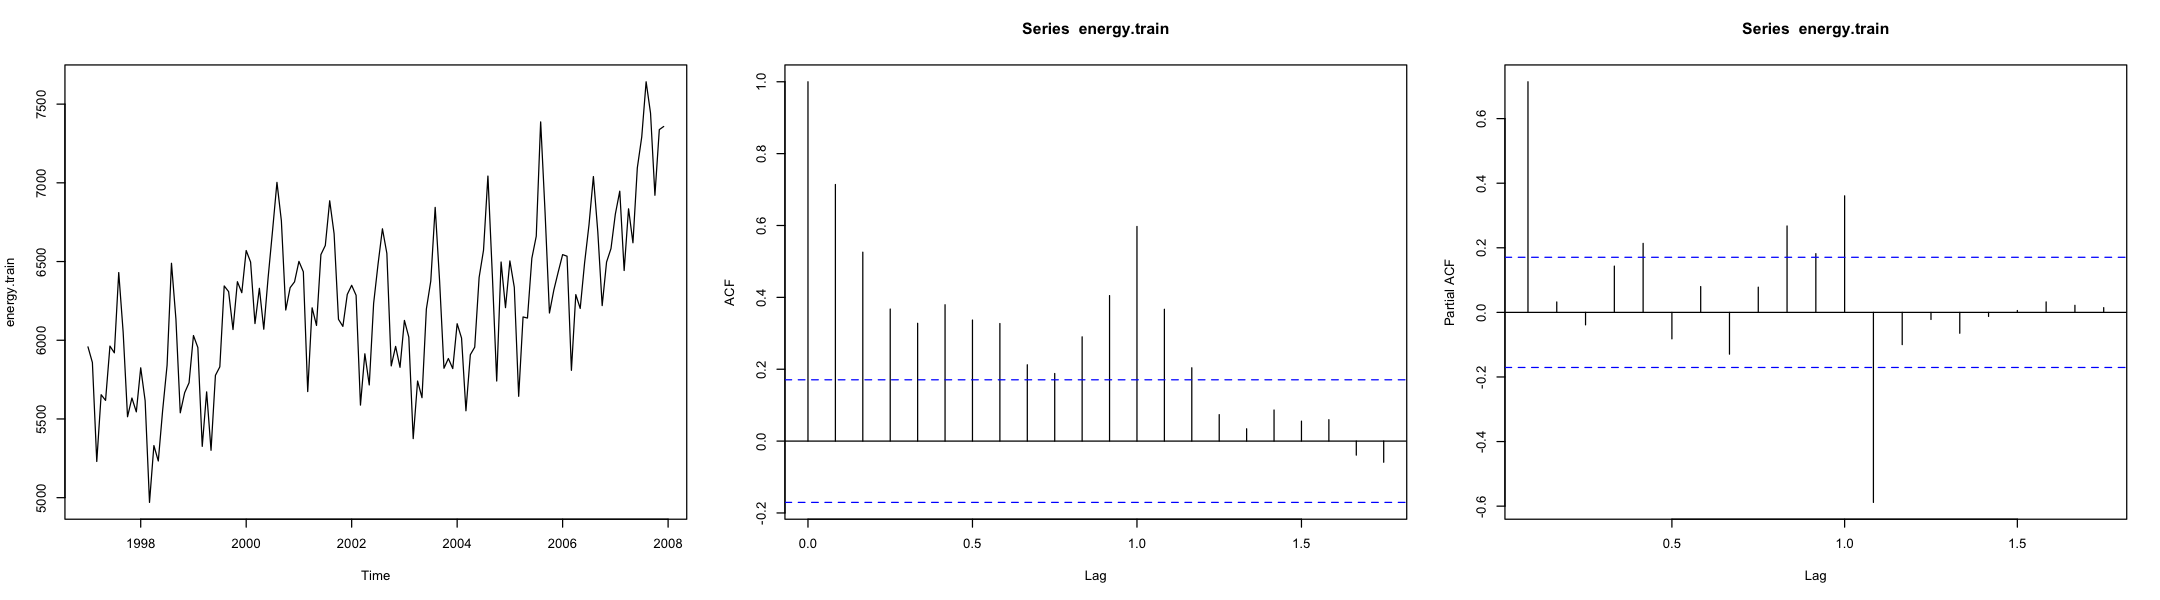

In [32]:
#Non-seasonal component
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,3))
plot(energy.train)
acf(energy.train)
pacf(energy.train)

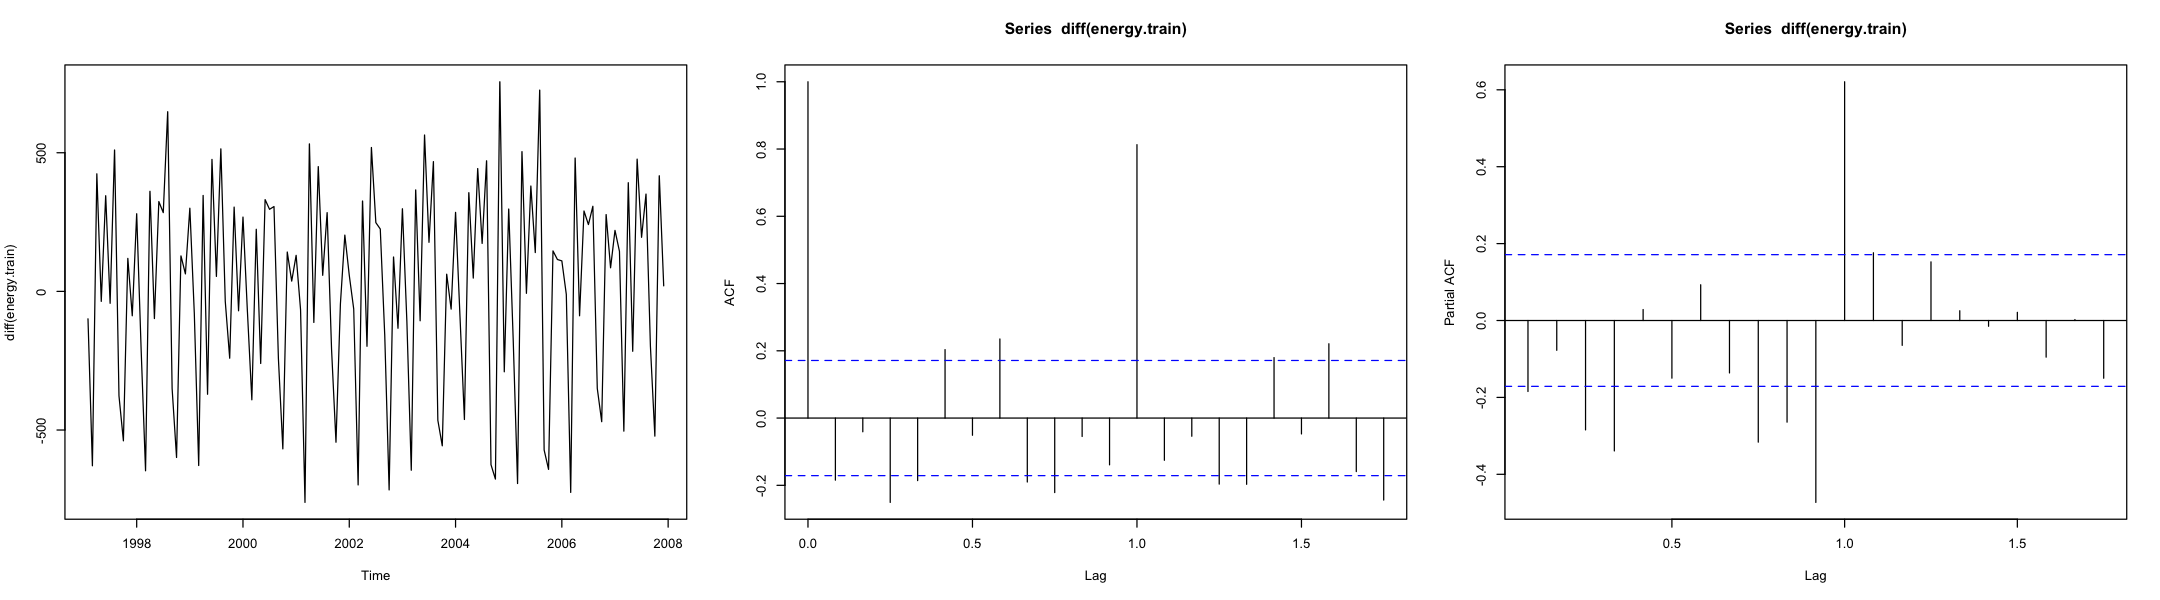

In [33]:
#Non-seasonal component - 1st differencing
options(repr.plot.width=18, repr.plot.height=5)
par(mfrow=c(1,3))
plot(diff(energy.train))
acf(diff(energy.train))
pacf(diff(energy.train))

Warning message in modeldf.default(object):
“Could not find appropriate degrees of freedom for this model.”


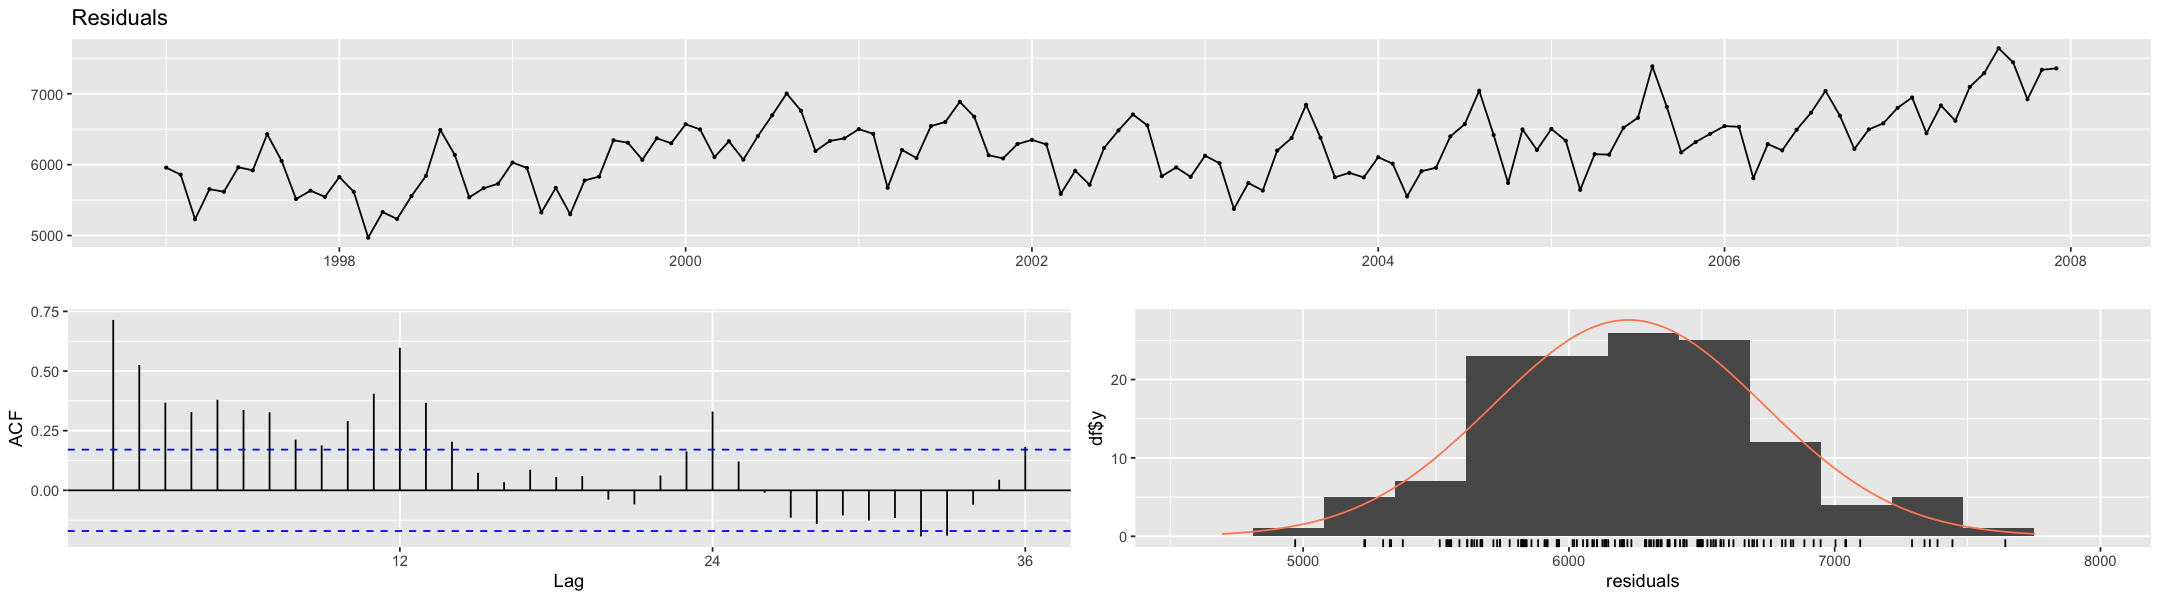

In [34]:
checkresiduals(energy.train)

On the other hand, ACF of the differenced seasonal component's 1st difference shows significant autocorrelation at lag 12, while on the PACF significant lags at lag 12 and 24 slowly decays. Therefore seasonal MA(1) can be applied with a 1st-order difference.

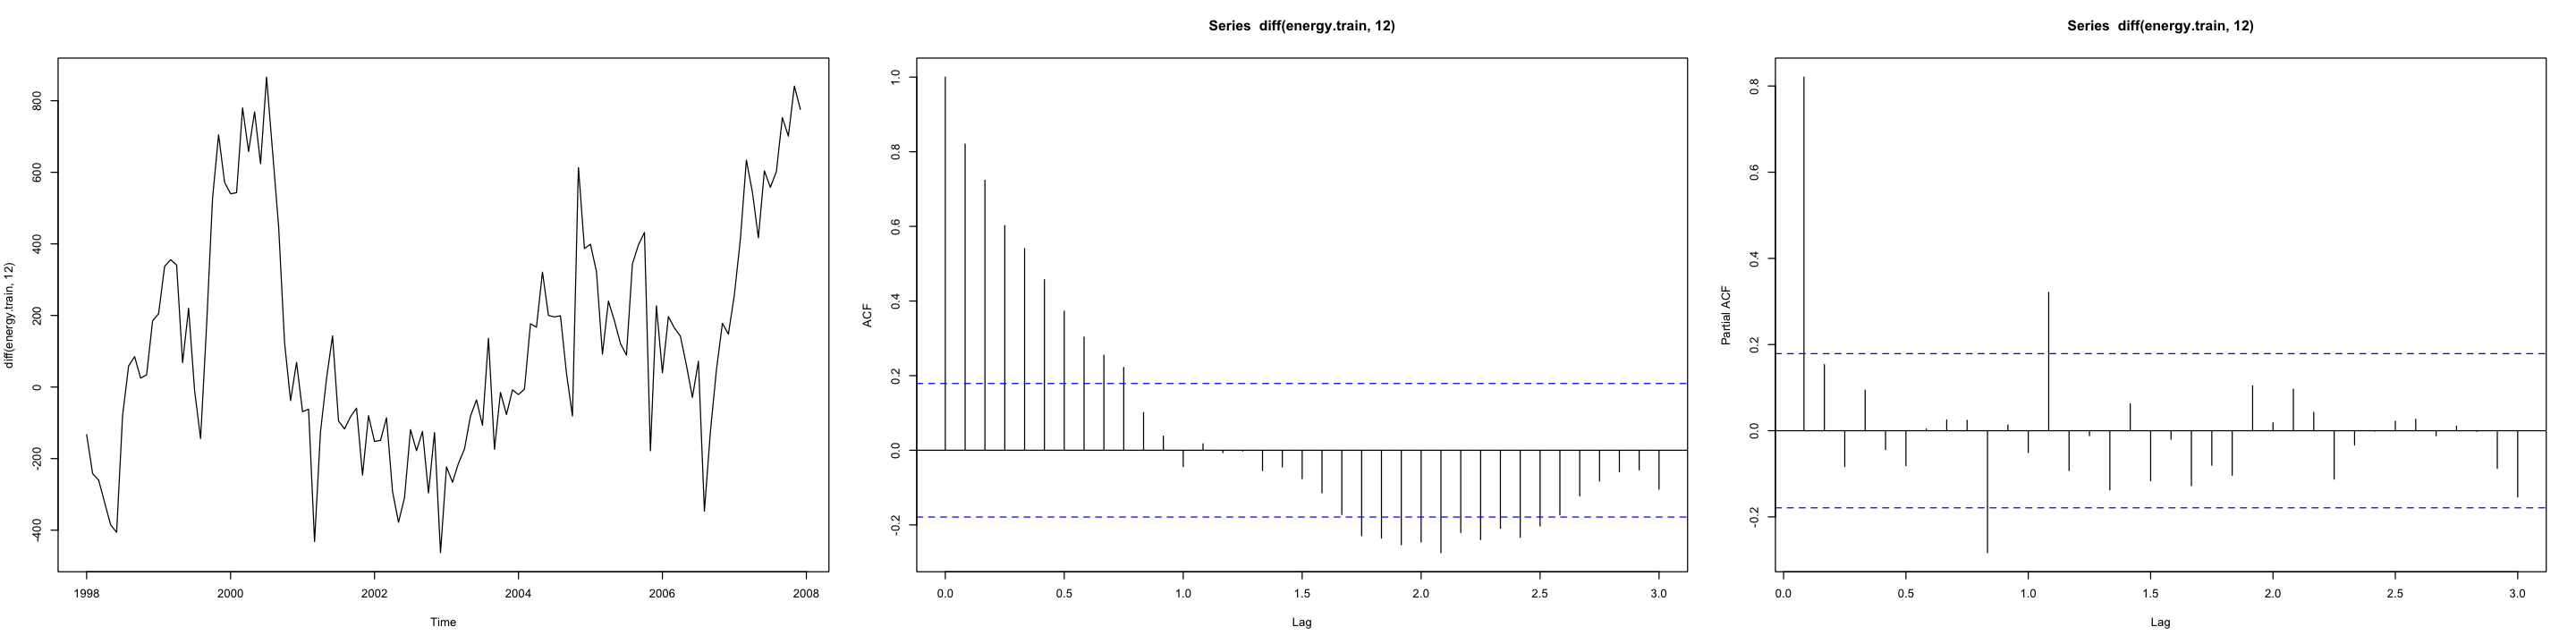

In [35]:
#Seasonal component 
options(repr.plot.width=24, repr.plot.height=6)
par(mfrow=c(1,3))
plot(diff(energy.train,12))
acf(diff(energy.train,12),lag.max=36)
pacf(diff(energy.train,12),lag.max=36)

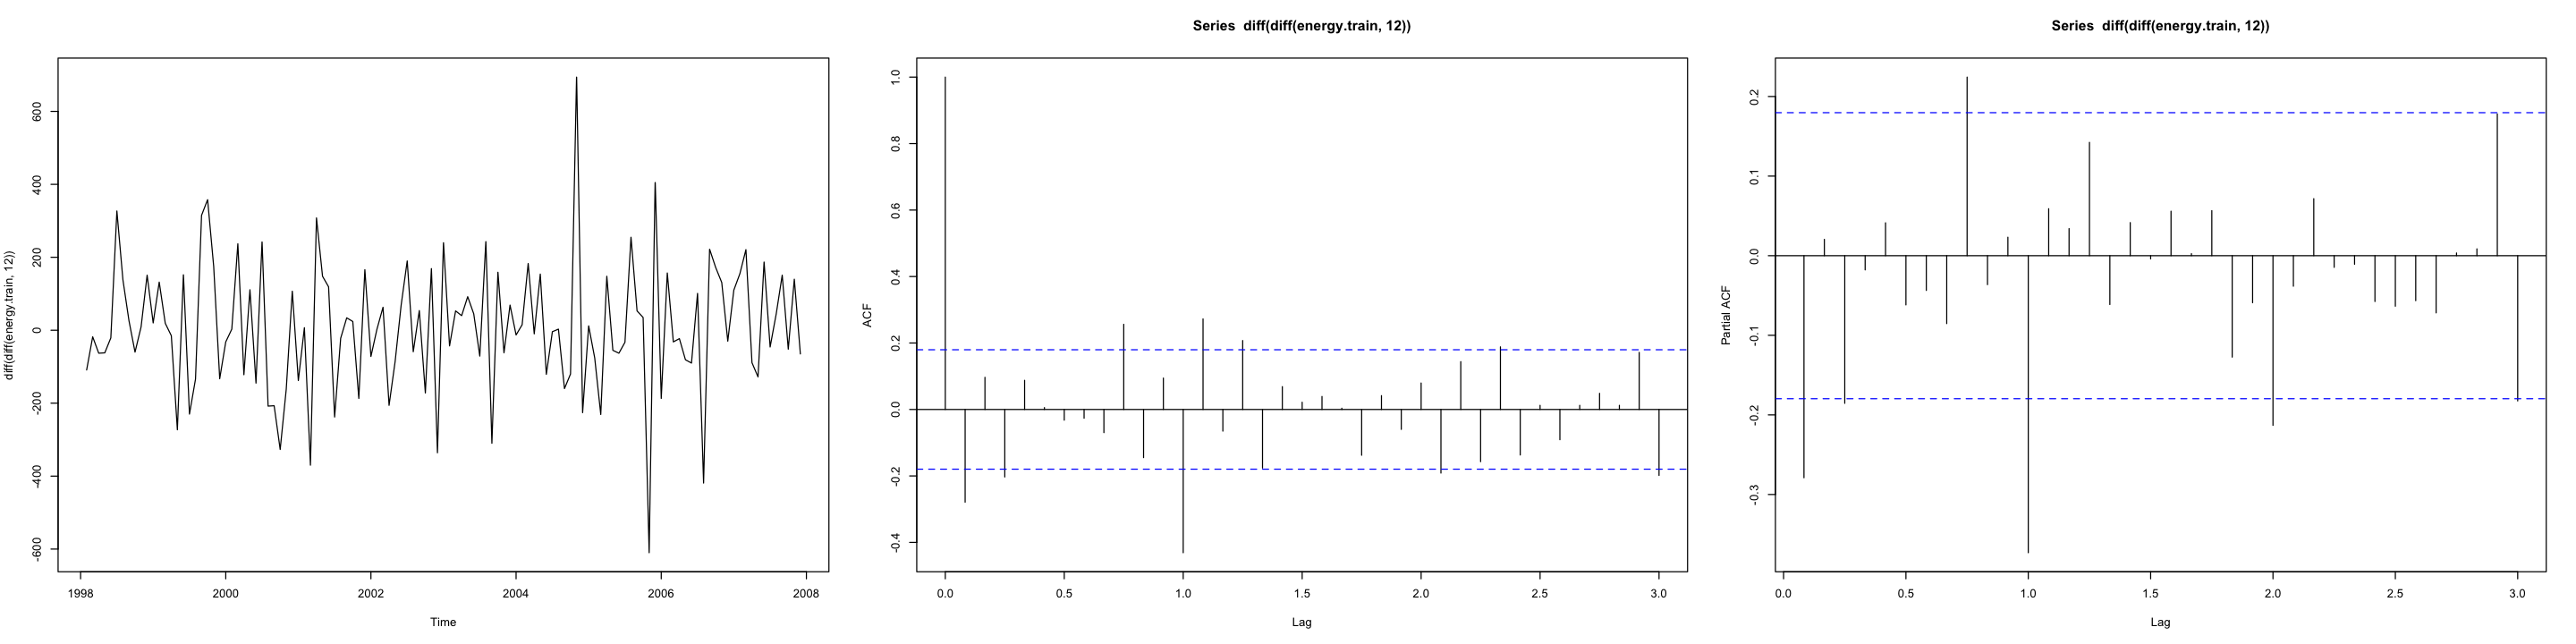

In [36]:
#Seasonal component - 1st differencing
options(repr.plot.width=24, repr.plot.height=6)
par(mfrow=c(1,3))
plot(diff(diff(energy.train,12)))
acf(diff(diff(energy.train,12)),lag.max=36)
pacf(diff(diff(energy.train,12)),lag.max=36)

## Model plot 

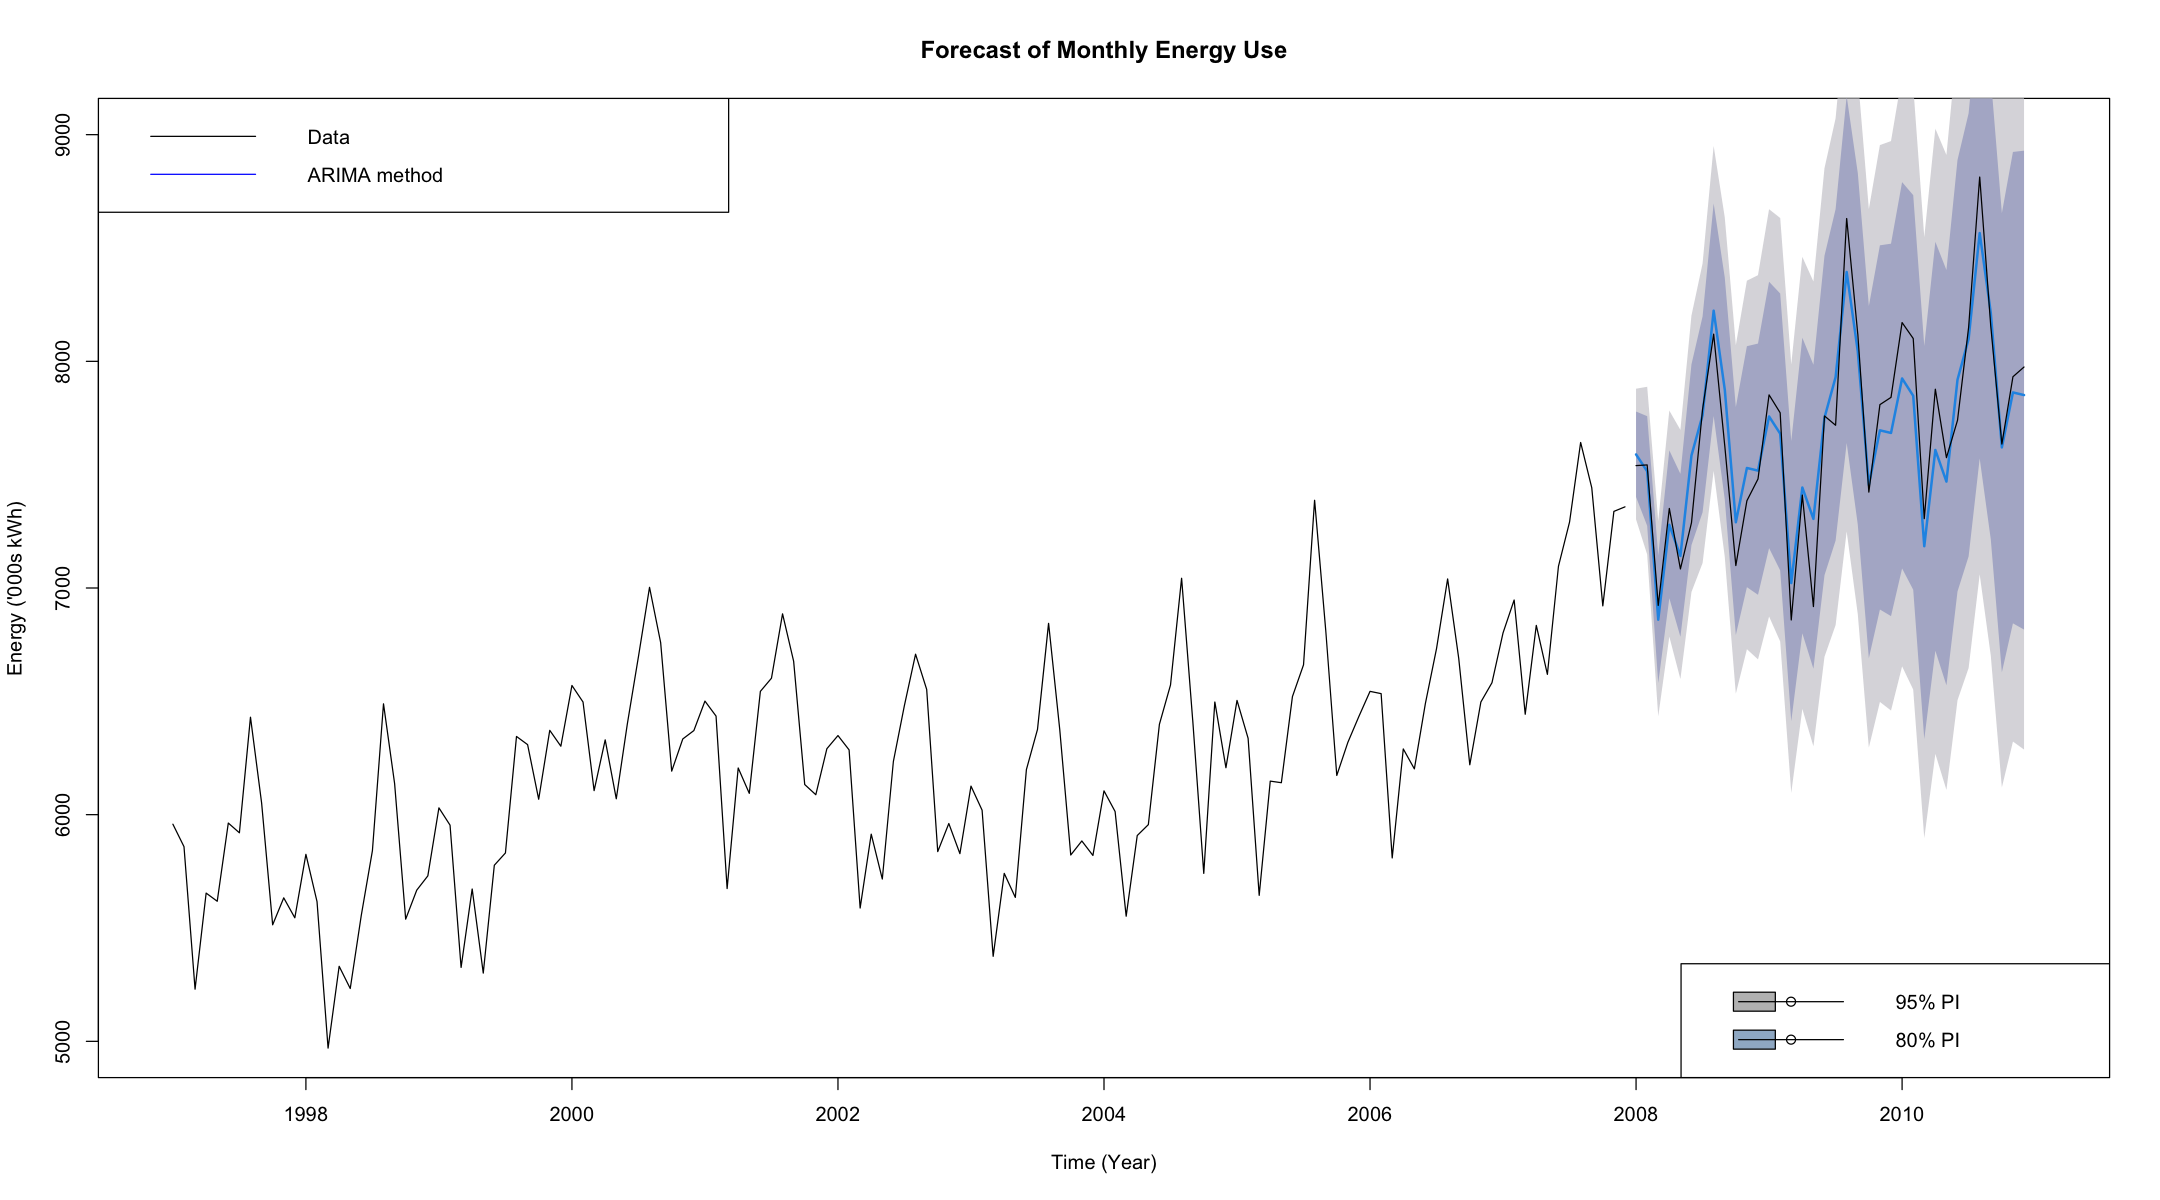

In [37]:
options(repr.plot.width=18, repr.plot.height=10)
plot(forecast(energy_arima,36), xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Forecast of Monthly Energy Use",xlim=c(1997,2011),ylim=c(5000,9000))
lines(energy.test)
legend("topleft",lty=1,col=c('black','blue'), legend=c("Data","ARIMA method"))
legend("bottomright",lty=1, fill=c("gray","slategray3"), c("95% PI", "80% PI"),pch=1) 

## Goodness of fit 

In [54]:
ARIMA <- c("ARIMA(1,1,0)(0,1,1)[12]", "ARIMA(0,1,13)(0,1,0)[12]", "ARIMA(1,1,0)(2,1,0)[12]")
AICc <- c(round(energy_arima$aicc,1),
                              round(energy_arima2$aicc,1),
                              round(energy_autoarima$aicc,1))
arima_aiccs <- cbind(ARIMA, AICc)
arima_aiccs

ARIMA,AICc
"ARIMA(1,1,0)(0,1,1)[12]",893.9
"ARIMA(0,1,13)(0,1,0)[12]",917.2
"ARIMA(1,1,0)(2,1,0)[12]",1548.2


The ARIMA(1,1,0)(0,1,1)[12] model with constant has lowest AICc, thus highest goodnest of fit compared to other ARIMA models.

## Accuracy measures 

In [39]:
arima_acc <- accuracy(forecast(energy_arima,h=36),energy.test)
arima_acc

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,9.073994,127.8565,92.79806,0.12213124,1.475045,0.3502034,-0.01288864,NA
Test set,7.579532,159.6532,129.43346,0.02805846,1.686085,0.4884589,0.29152399,0.3357126


## Accuracy of forecasts 

In [40]:
method3 <- c("mean method", "naive method", "seasonal naive method", "drift method","arima method")

arima.basic_acc <- cbind(method3,rbind(round(mean_acc[2,c(2,3,5,6)],1),
                    round(naive_acc[2,c(2,3,5,6)],1),
                    round(snaive_acc[2,c(2,3,5,6)],1),
                    round(drift_acc[2,c(2,3,5,6)],1),
                    round(arima_acc[2,c(2,3,5,6)],1)
                                          ))
arima.basic_acc

method3,RMSE,MAE,MAPE,MASE
mean method,1528.5,1463.8,18.8,5.5
naive method,550.1,443.2,5.6,1.7
seasonal naive method,698.7,626.8,8,2.4
drift method,416,328.5,4.2,1.2
arima method,159.7,129.4,1.7,0.5


The ARIMA method performs better than all of the previous basic models. This model has lower values accross all 4 RMSE, MAE, MAPE, and MASE indicators. The forecast line is also following the test set closely.

## Residual diagnostics 

In [41]:
#Mean residuals
arima_res <- residuals(energy_arima)
mean_arima_res <- mean(arima_res,nam.rm=TRUE)
mean_arima_res

[1] 0.6180898


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)(0,1,1)[12]
Q* = 17.53, df = 22, p-value = 0.7335

Model df: 2.   Total lags used: 24



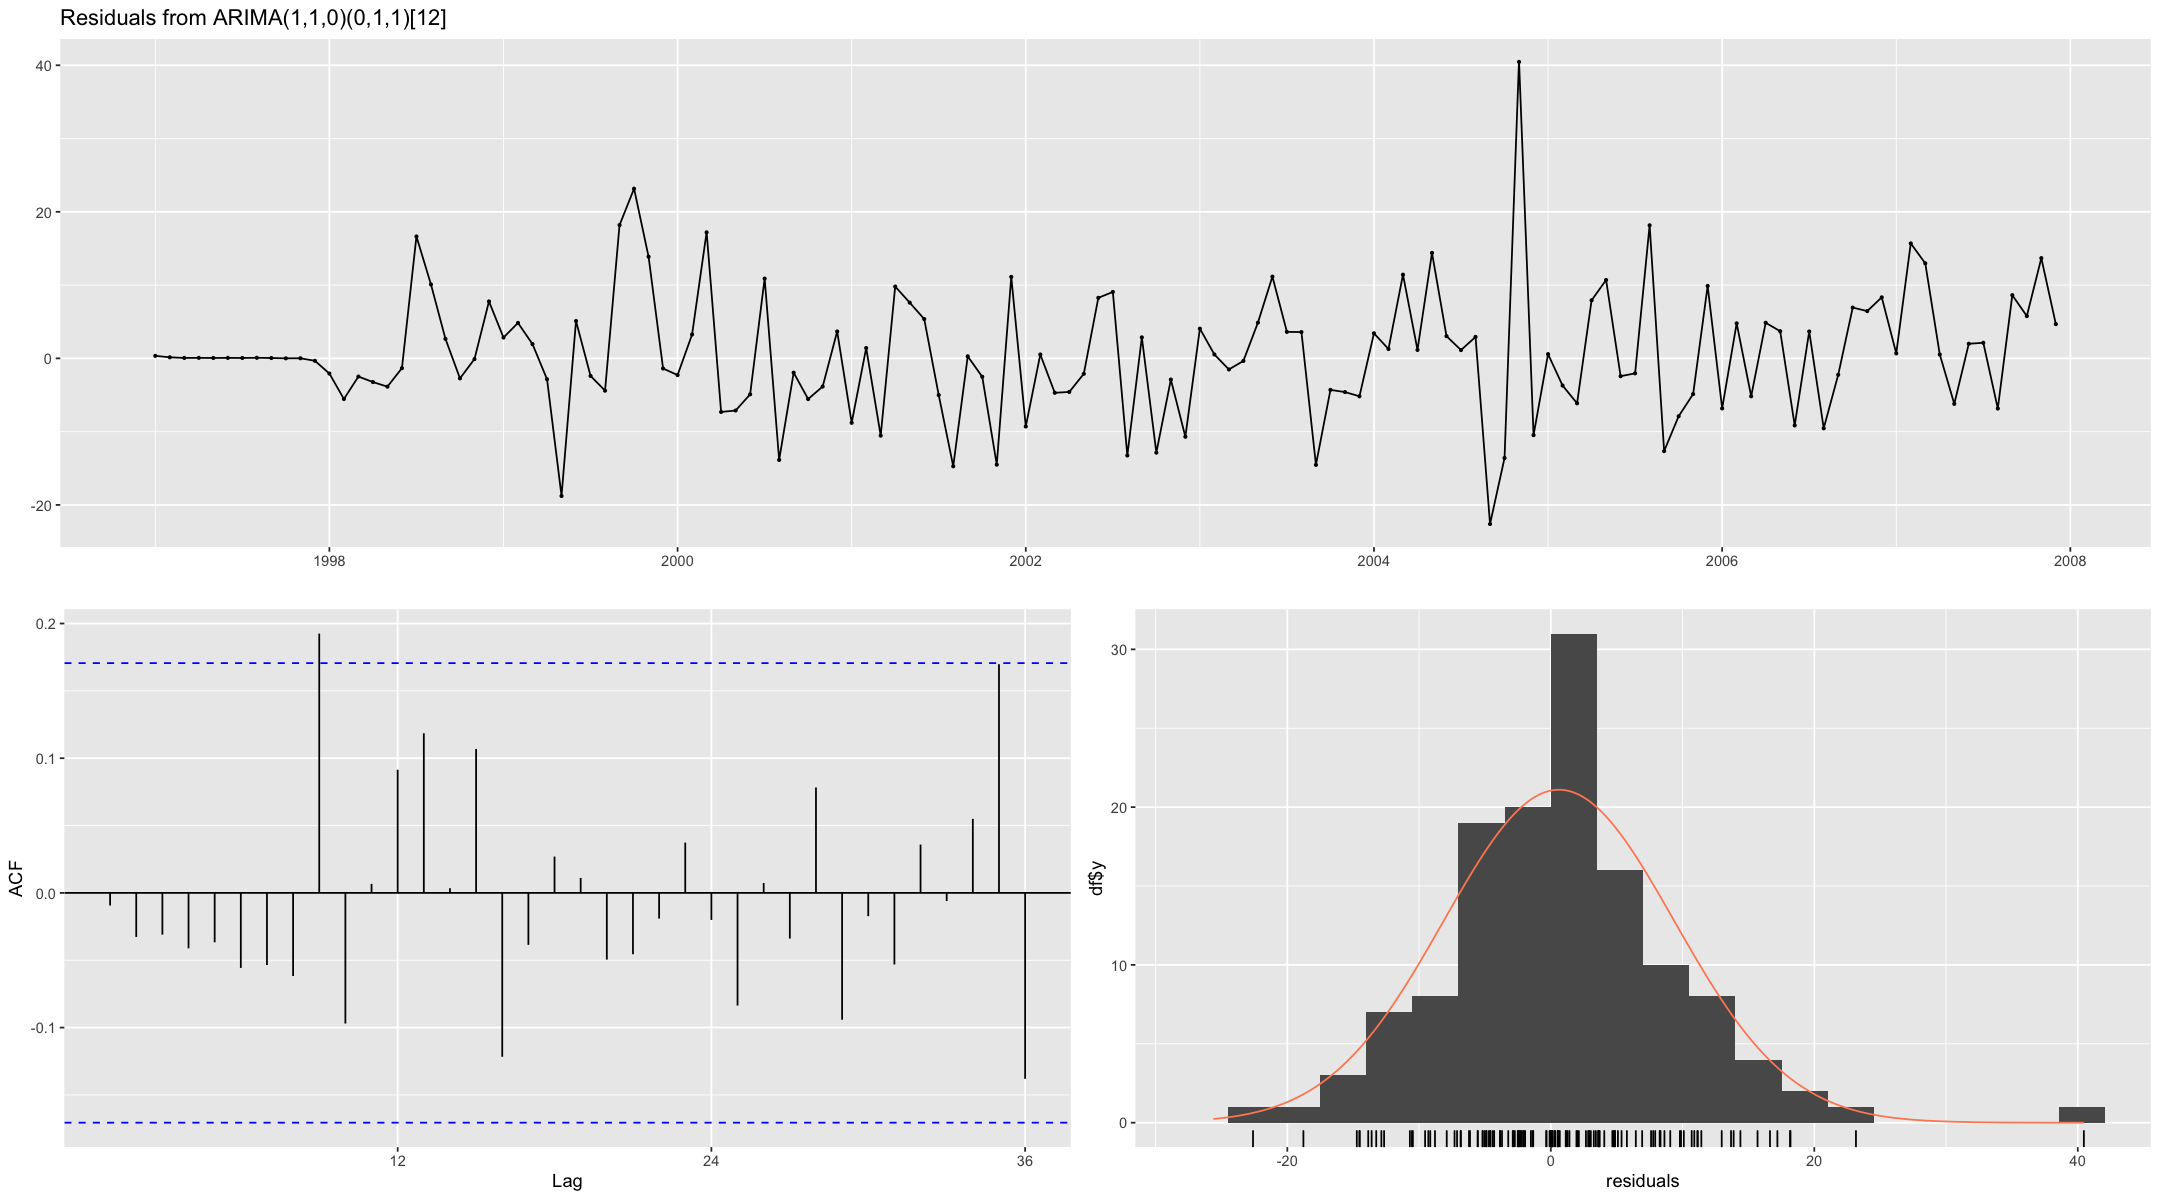

In [42]:
#Visualization
checkresiduals(energy_arima)

Mean residuals is relatively close to 0, which means little-to-no bias.  
There is only 1 significant autocorrelation at lag 9.  
Variance of residuals stays approximately constant through time.    
Residuals are approximately normally distributed.  

 
### Portmanteau autocorrelation test
    

In [43]:
Box.test(arima_res, type="Ljung", lag=24)


	Box-Ljung test

data:  arima_res
X-squared = 17.53, df = 24, p-value = 0.8252


H0: the first 24 autocorrelations are not significantly different from a white noise process    
HA: the first 24 autocorrelations are significantly different from a white noise process

Lags tested: 24

Test statistics: 17.53

p-value: 0.8252 ( > 0.05)

We cannot reject the hypothesis that there are no significant autocorrelations for the first 24 lags of the residuals.

----

<div class="alert alert-block alert-warning">
<a id="Comparison"></a>
    
# Comparison of models 
    
</div>

The **ARIMA model** performs best of all models presented here.   

Based on the plot, the ARIMA and the ETS models can capture both trend and seasonality better than the basic model. However, the ARIMA model can follows the plotted test data closer as the time series progress into the future.

Based on accuracy measures, both ARIMA and ETS models have much lower error values than the basic models. However, the ARIMA model performs slightly better in this regards compared to the ETS model.

This is further cemented when the ARIMA model also has lower AICc, hence better goodness of fit, than the ETS model.

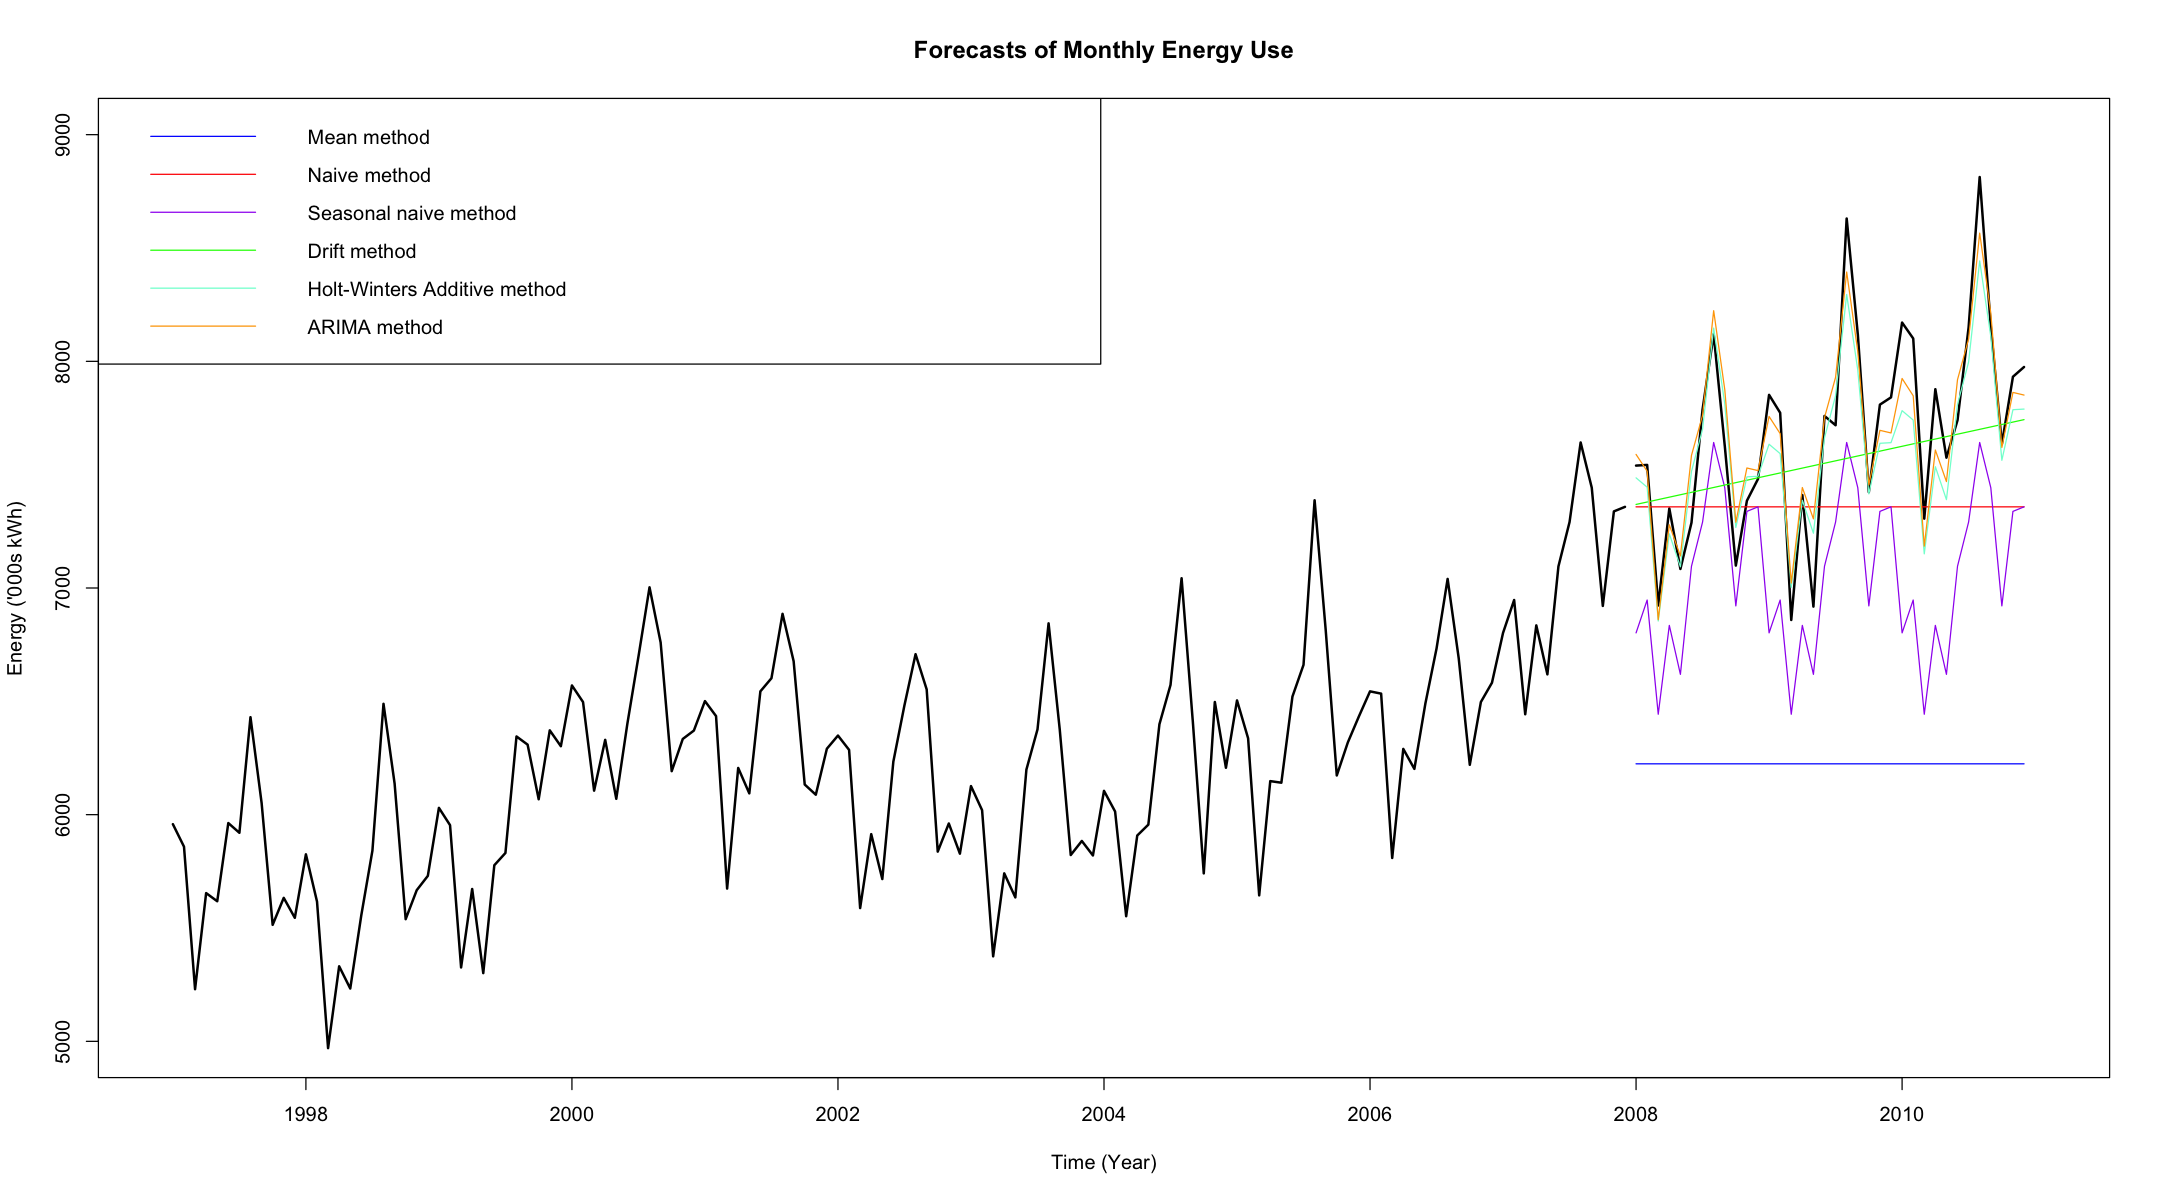

In [44]:
plot(energy.train, lwd=2, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Forecasts of Monthly Energy Use",xlim=c(1997,2011),ylim=c(5000,9000))
lines(energy.test, lwd=2)
lines(energy_mean$mean,col='blue')
lines(energy_naive$mean,col='red')
lines(energy_snaive$mean,col='purple')
lines(energy_drift$mean,col='green')
lines(energy_hwa$mean, col = 'aquamarine')
lines(forecast(energy_arima,36)$mean, col = 'orange')
legend("topleft",lty=1,col=c('blue','red','purple','green','aquamarine','orange'), legend=c("Mean method","Naive method","Seasonal naive method","Drift method","Holt-Winters Additive method","ARIMA method"))

In [45]:
method4 <- c("mean method", "naive method", "seasonal naive method", "drift method","holt-winters additive method","arima method")

arima.hwa.basic_acc <- cbind(method4,rbind(round(mean_acc[2,c(2,3,5,6)],1),
                    round(naive_acc[2,c(2,3,5,6)],1),
                    round(snaive_acc[2,c(2,3,5,6)],1),
                    round(drift_acc[2,c(2,3,5,6)],1),
                    round(hwa_acc[2,c(2,3,5,6)],1),
                    round(arima_acc[2,c(2,3,5,6)],1)
                                          ))
arima.hwa.basic_acc

method4,RMSE,MAE,MAPE,MASE
mean method,1528.5,1463.8,18.8,5.5
naive method,550.1,443.2,5.6,1.7
seasonal naive method,698.7,626.8,8,2.4
drift method,416,328.5,4.2,1.2
holt-winters additive method,189,155.9,2,0.6
arima method,159.7,129.4,1.7,0.5


In [46]:
Nonbasic_methods <- c("HWA","ARIMA")
AIC.c <- c(round(energy_hwa$model$aicc,1), round(energy_arima$aicc,1))
nonbasic_aiccs <- cbind(Nonbasic_methods, AIC.c)

nonbasic_aiccs

Nonbasic_methods,AIC.c
HWA,1961.2
ARIMA,893.9


<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    
# Forecasts 
</div>

In [47]:
fin_forecast <- forecast(energy_arima,72)

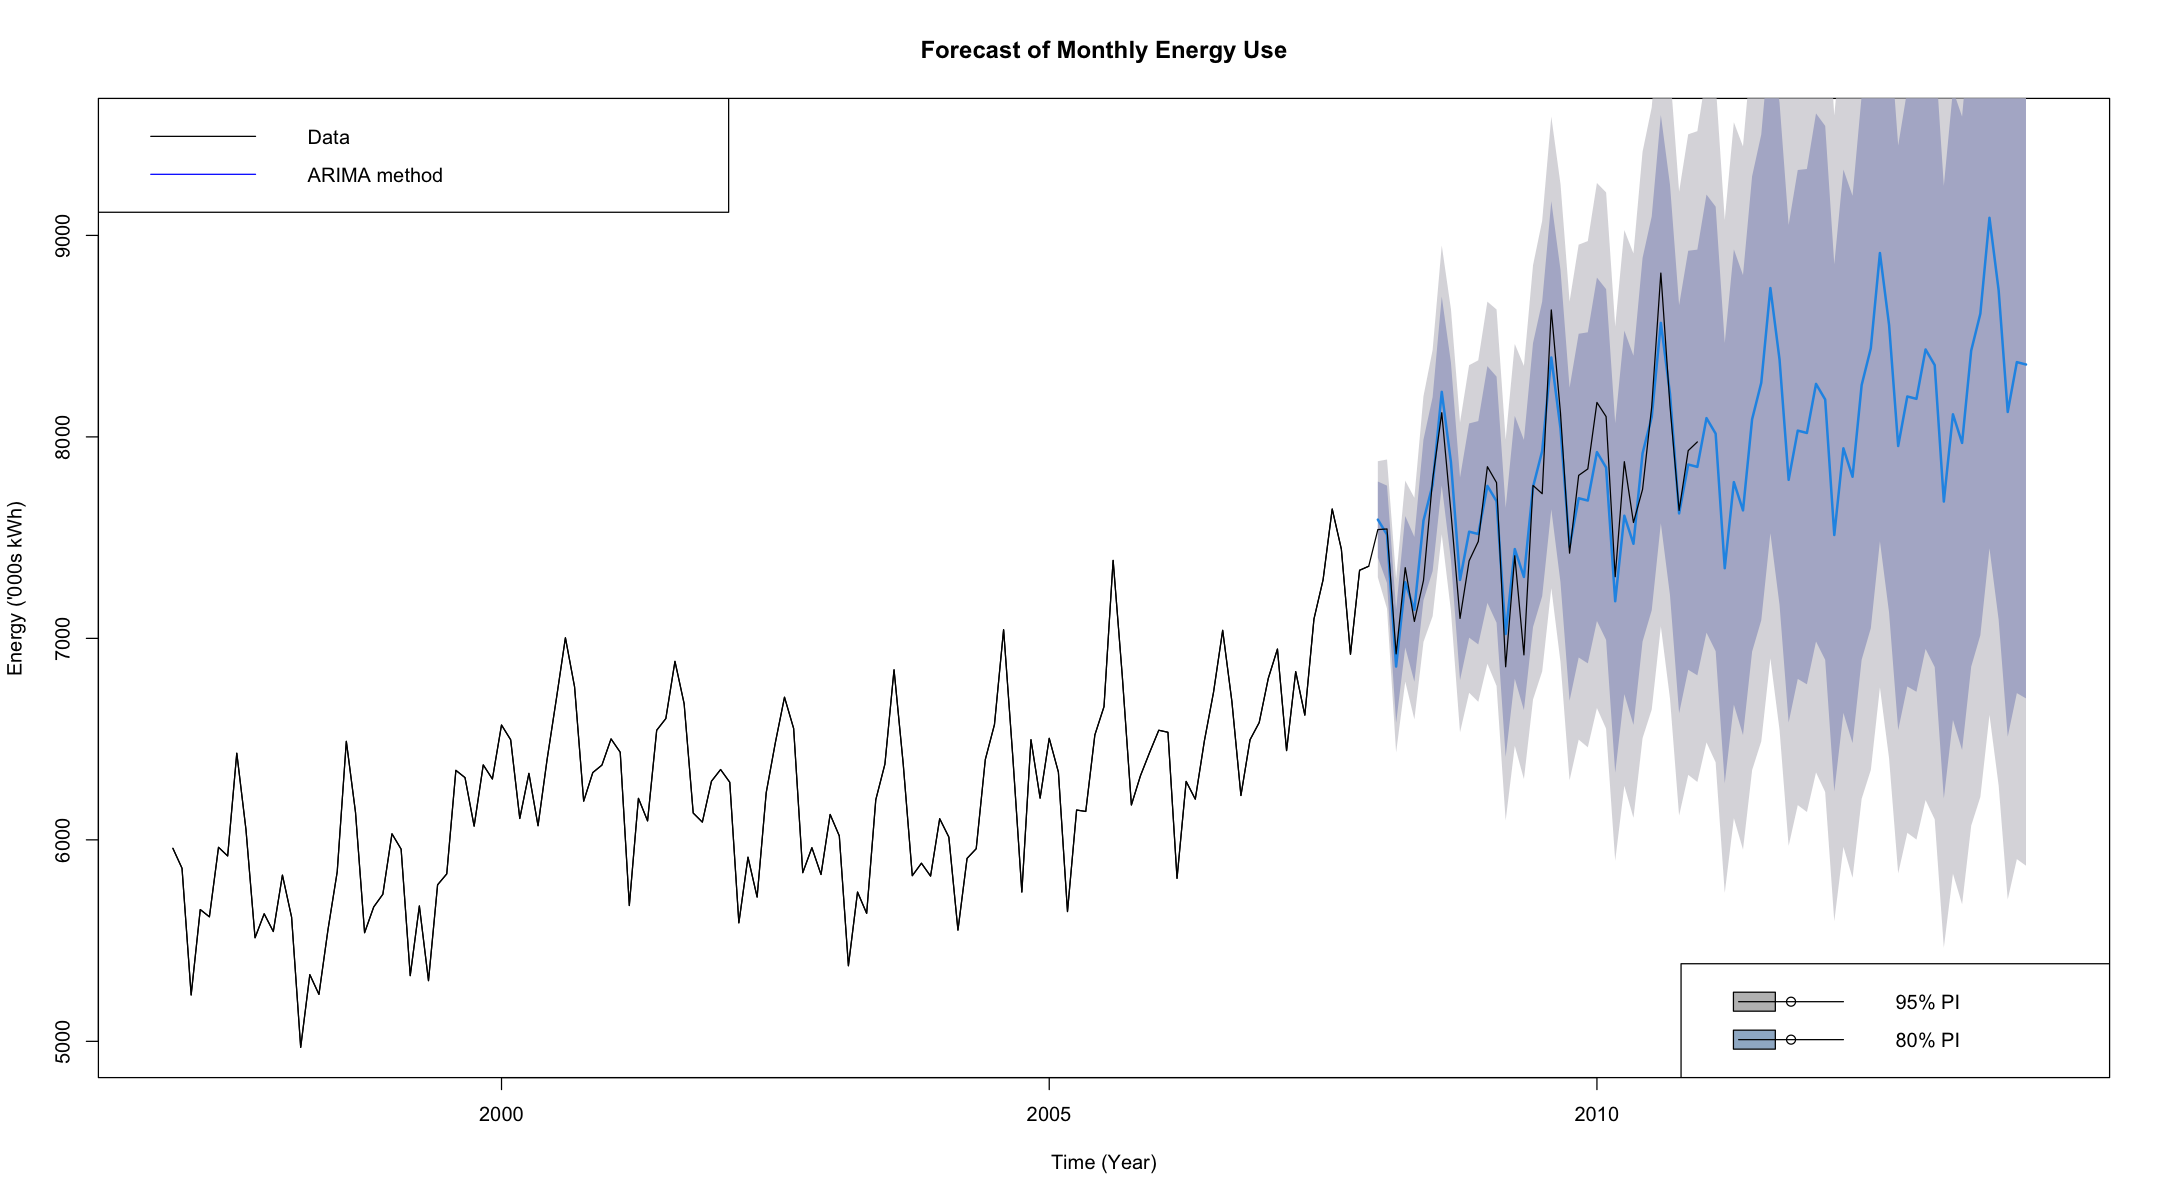

In [48]:
options(repr.plot.width=18, repr.plot.height=10)
plot(fin_forecast, xlab="Time (Year)", ylab="Energy ('000s kWh)", main="Forecast of Monthly Energy Use",xlim=c(1997,2014),ylim=c(5000,9500))
lines(energy)
legend("topleft",lty=1,col=c('black','blue'), legend=c("Data","ARIMA method"))
legend("bottomright",lty=1, fill=c("gray","slategray3"), c("95% PI", "80% PI"),pch=1) 

<div class="alert alert-block alert-warning">
<a id="Discussion"></a>

# Discussion 
</div>


**1. The model may not be able to forecast the correct trend:** This is due to the fact that the training dataset has a significant middle portion where the trend is relatively flat. This trend quickly increases again in the later period and in the test set. Therefore, it might not be able to follow the rising trend quick enough for the futur forecast.   


**2. The model may not be able to forecast the correct seasonal variation:** Similarly, the training set has fairly constant seasonal variation. However, as the trend increases, seasonal variation can also start to increase and the ARIMA model might not capture that.   
    
**3. Lack of robust forecasting capability:** A weakness of the ARIMA model is that it cannot capture or forecast outliers well. Therefore, it might not be able to follow swift changes in the data and fail to forecast extreme values.


**RECOMMENDATIONS**:           

a) Train the ARIMA model on a dataset that exhibits stronger variation.   
b) Use other models that can capture huge trend changes and robustness, such as ETS multiplicative models. 




<div class="alert alert-block alert-success">
<a id="Explanatory"></a>

# Explanatory model 
</div>

As explored for data decomposition, it is possible that the energy demand at YVR is affected by total passengers travelling through the airport. It is also slightly affected by changes in terminal services area.

First, we would also need to forecast the *total passenger* and *area* variables into the forecasting horizon. We can also use *domestic passenger*, *international passenger*, and *US passenger* separately if we believe these variables contribute to the regression differently. Each variable can use a different forecasting model, based on decomposition, residuals, and ACF/PACF analysis.

After we have obtained the future values of the above variables, we will use them to build a multi-linear regression model.

----

<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix A:
# ETS models 
</div>

In [49]:
#Holt-Winters multiplicative method
energy_hwm <- hw(energy.train, seasonal = 'multiplicative', damped=FALSE, h =36)
summary(energy_hwm)


Forecast method: Holt-Winters' multiplicative method

Model Information:
Holt-Winters' multiplicative method 

Call:
 hw(y = energy.train, h = 36, seasonal = "multiplicative", damped = FALSE) 

  Smoothing parameters:
    alpha = 0.4706 
    beta  = 1e-04 
    gamma = 0.0072 

  Initial states:
    l = 5875.9098 
    b = 8.9647 
    s = 0.9826 0.9884 0.9611 1.0515 1.1023 1.0388
           1.0155 0.9525 0.9714 0.9096 1.0082 1.0182

  sigma:  0.0237

     AIC     AICc      BIC 
1978.826 1984.195 2027.834 

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE      ACF1
Training set 5.731122 136.4113 105.8658 0.02292035 1.702491 0.3995188 0.3457665

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2008       7517.507 7289.219 7745.795 7168.371 7866.643
Feb 2008       7450.360 7200.345 7700.374 7067.995 7832.724
Mar 2008       6729.247 6483.871 6974.624 6353.977 7104.518
Apr 2008       7196.257 6914.518 7477.997 6765.374 7627.140
M

In [50]:
#ETS auto method
energy_ets <- ets(energy.train)
summary(energy_ets)

ETS(A,N,A) 

Call:
 ets(y = energy.train) 

  Smoothing parameters:
    alpha = 0.8142 
    gamma = 1e-04 

  Initial states:
    l = 6028.2465 
    s = -53.9951 -35.1353 -238.2527 322.9962 671.4127 226.3734
           66.8415 -359.4489 -191.2235 -589.7391 56.3954 123.7755

  sigma:  133.9544

     AIC     AICc      BIC 
1952.670 1956.808 1995.912 

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 12.73609 126.6517 98.09986 0.1709555 1.569775 0.3702114 -0.0144411

---

<div class="alert alert-block alert-danger">
<a id="AppendixB"></a>

# Appendix B:
# ARIMA Models
</div>

In [51]:
#ARIMA(0,1,13)x(0,1,0)x12 without constant method
energy_arima2 <- Arima(energy.train,order=c(0,1,13),seasonal=c(0,1,0),include.constant=FALSE,lambda = lambda)
energy_arima2


Series: energy.train 
ARIMA(0,1,13)(0,1,0)[12] 
Box Cox transformation: lambda= 0.6931483 

Coefficients:
          ma1      ma2     ma3      ma4      ma5     ma6      ma7      ma8
      -0.1777  -0.0094  0.0037  -0.0437  -0.0243  0.0482  -0.0694  -0.0378
s.e.   0.1356   0.1343  0.1426   0.1315   0.1180  0.1775   0.1287   0.1231
         ma9     ma10    ma11     ma12    ma13
      0.1179  -0.0378  0.0148  -0.8884  0.1661
s.e.  0.1479   0.1394  0.1532   0.2096  0.1234

sigma^2 = 94.07:  log likelihood = -442.6
AIC=913.19   AICc=917.23   BIC=952.1

In [52]:
#ARIMA auto method
energy_autoarima <- auto.arima(energy.train, stepwise=FALSE, approximation=FALSE)
energy_autoarima


Series: energy.train 
ARIMA(1,1,0)(2,1,0)[12] 

Coefficients:
          ar1     sar1     sar2
      -0.2482  -0.4993  -0.2136
s.e.   0.0909   0.0937   0.1006

sigma^2 = 24330:  log likelihood = -769.95
AIC=1547.9   AICc=1548.25   BIC=1559.01